# Project- Fleet Service Division (FSD)
Analyse the utilisation of fleet vehicles to identify underused assets and make data-driven recommendations for optimising the fleet size and composition, improving efficiency, safety and cost-effectiveness. 

# Optimizing Fleet Utilization 

# Problem Definition
  Objective: 
  The objective in this project is to identify underutilized and overutilized vehicles to optimize fleet size and composition.

  Key Questions:

- Which vehicles are underutilized or overutilized? - Calculate utilization rate, Compare vehicles of the same type to identify outliers (either underutilized or overutilized).
- How does utilization vary across departments and times of the year?
- What is the optimal number and type of vehicles needed to meet demand?


# Data Collection
Simulated dataset for Fleet Service Division (FSD) @ City of Toronto

# Data overview
The dataset contains 1500 records of information related to fleet assets used by the City of Toronto. The main objective of this dataset is to analyze vehicle utilization and optimize fleet size and composition. The dataset includes various attributes that describe the vehicles' characteristics, usage, and associated costs.

Dataset Columns 
- Asset_ID: A unique identifier for each vehicle or piece of equipment in the fleet.
- Asset_Type: The type of asset, such as Heavy Vehicle, Light Vehicle, or Special Equipment.
- Purchase_Date: The date on which the asset was purchased. This can help in analyzing the age of the asset and its lifecycle stage.
- Lifecycle_Status: The current lifecycle status of the asset, e.g., In Service, End of Life. This indicates whether the asset is still in use or has   been decommissioned.
- Maintenance_Costs: The total cost incurred for maintaining the asset over its lifetime.
- Replacement_Cost:The estimated cost to replace the asset with a new one. This is useful for financial planning and decision-making.
- Depreciation_Value: The depreciation value of the asset, representing how much value it has lost over time.
- Fuel_Type: The type of fuel the asset uses, such as Gasoline or Electric. This can impact both costs and environmental considerations.
- Fuel_Efficiency: The efficiency of the asset's fuel consumption, typically measured in kilometers per liter or miles per gallon.
- Mileage: The total distance traveled by the asset, usually measured in kilometers. This is a key indicator of vehicle usage.
- Hours_in_Use: The total hours the asset has been in use. This metric helps assess the intensity of use beyond just distance traveled.
- Department: The department to which the asset is assigned, such as Public Works, Transportation, or Emergency Services. This helps in analyzing usage patterns across different city departments.
- Trips_per_Year:The number of trips the asset makes per year. This is another key indicator of how frequently the vehicle is being used.

# Read the dataset into a spark dataframe

In [4]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("FleetDataAnalysis").getOrCreate()

# Load the dataset into a Spark DataFrame
dataset_path = 'Files/fleet_utilisation_dataset/fleet_asset.csv'
spark_df = spark.read.csv(dataset_path, header=True, inferSchema=True)

# take look at the first few rows of the Spark DataFrame 
spark_df.show(5)

# Print the schema of the DataFrame
spark_df.printSchema()


StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 6, Finished, Available, Finished)

+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+------------------+--------------+
|  Asset_ID|       Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|        Department|Trips_per_Year|
+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+------------------+--------------+
|ASSET_0001|Special Equipment|   16/01/2017|     End of Life|            15005|           99893|             18286| Gasoline|            9.0|  79626|         307|Emergency Services|            94|
|ASSET_0002|    Heavy Vehicle|   05/10/2011|      In Service|            23361|           51162|             15466| Gasoline|           2.69|  50860|        1679|    Transportation|            51|
|ASSET_0003|   

In [5]:
# Count the number of columns
num_columns = len(spark_df.columns)
print(f"Number of columns: {num_columns}")

# Count the number of rows
num_rows = spark_df.count()
print(f"Number of rows: {num_rows}")


StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 7, Finished, Available, Finished)

Number of columns: 13
Number of rows: 1500


So, the dataframe has 13 columns and 1500 records. 

# Data Cleaning 

In [6]:
# To ensure consistency in the date format, we convert Purchase_Date column to a proper date format (yyyy-mm-dd) 
from pyspark.sql.functions import to_date

spark_df = spark_df.withColumn("Purchase_Date", to_date(spark_df["Purchase_Date"], "dd/MM/yyyy"))


StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 8, Finished, Available, Finished)

In [7]:
# Let's take a look at the dataframe to ensure that the date format has been changed.
spark_df.show(5)

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 9, Finished, Available, Finished)

+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+------------------+--------------+
|  Asset_ID|       Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|        Department|Trips_per_Year|
+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+------------------+--------------+
|ASSET_0001|Special Equipment|   2017-01-16|     End of Life|            15005|           99893|             18286| Gasoline|            9.0|  79626|         307|Emergency Services|            94|
|ASSET_0002|    Heavy Vehicle|   2011-10-05|      In Service|            23361|           51162|             15466| Gasoline|           2.69|  50860|        1679|    Transportation|            51|
|ASSET_0003|   

In [8]:
# Check for missing values
from pyspark.sql.functions import col, count, when, isnull

# Use the select statement to count nulls in each column
spark_df.select([count(when(isnull(c), c)).alias(c) for c in spark_df.columns]).show()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 10, Finished, Available, Finished)

+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+
|Asset_ID|Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|Department|Trips_per_Year|
+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+
|       0|         0|            0|               0|                0|               0|                 0|        0|              0|      0|           0|         0|             0|
+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+



In [9]:
# Drop rows with missing critical information
spark_df = spark_df.dropna(subset=["Asset_ID", "Asset_Type", "Lifecycle_Status"])

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 11, Finished, Available, Finished)

# Why are we doing this?
- Dropping rows where Asset_ID is missing ensures that each row in the dataset refers to a specific, identifiable asset.
- Missing Asset_Type values might lead to incorrect analysis or the inability to correctly categorize assets. Dropping these rows helps maintain the integrity of categorical analysis.
- Missing Lifecycle_Status values can make it difficult to determine the asset’s current condition, which could skew results or lead to incorrect conclusions.



# Manage missing values if there're any

In [10]:
from pyspark.ml.feature import Imputer

# Define the imputer for the numerical columns "Fuel_Efficiency" and "Mileage"
imputer = Imputer(
    inputCols=["Fuel_Efficiency", "Mileage"],  # Columns with missing values
    outputCols=["Fuel_Efficiency", "Mileage"]  # Columns to overwrite with imputed values
)

# Fit the imputer on the DataFrame and transform the data
spark_df = imputer.fit(spark_df).transform(spark_df)

# Display the resulting DataFrame
spark_df.show()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 12, Finished, Available, Finished)

+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+--------------------+--------------+
|  Asset_ID|       Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|          Department|Trips_per_Year|
+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+--------------------+--------------+
|ASSET_0001|Special Equipment|   2017-01-16|     End of Life|            15005|           99893|             18286| Gasoline|            9.0|  79626|         307|  Emergency Services|            94|
|ASSET_0002|    Heavy Vehicle|   2011-10-05|      In Service|            23361|           51162|             15466| Gasoline|           2.69|  50860|        1679|      Transportation|            51|
|ASSE

In [11]:
# Identifying outliers in these columns: "Mileage","Maintenance_Costs", "Hours_in_Use", "Trips_per_Year", "Fuel_Efficiency", "Asset_Age
spark_df.describe("Mileage","Maintenance_Costs", "Hours_in_Use", "Trips_per_Year", "Fuel_Efficiency").show()


StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 13, Finished, Available, Finished)

+-------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|          Mileage| Maintenance_Costs|     Hours_in_Use|   Trips_per_Year|   Fuel_Efficiency|
+-------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|             1500|              1500|             1500|             1500|              1500|
|   mean|62397.99733333333|17064.937333333335|776.5813333333333|           96.808|3.5479066666666723|
| stddev|34501.51467085245| 7181.796462470827|450.4229419141789|43.22870516180938| 3.388697734063059|
|    min|            10155|              5000|              100|               20|               0.0|
|    max|           149657|             29988|             1997|              199|              10.0|
+-------+-----------------+------------------+-----------------+-----------------+------------------+



# Insights:
- The standard deviations are quite large for most features, which indicates a wide range in the data. This could suggest variability in the usage and maintenance of different vehicles.
- Potential Outliers: Mileage, Maintenance_Costs, Hours_in_Use, and Trips_per_Year columns show potential signs of outliers, particularly in the upper ranges. 
- The presence of a 0.0 value in Fuel_Efficiency is concerning and suggests that there might be vehicles with significant fuel inefficiencies or data recording issues.

In [12]:
# Let's Remove all rows with Fuel_Efficiency of 0.0
spark_df = spark_df.filter(spark_df.Fuel_Efficiency != 0.0)

# Display the first few rows to confirm the records have been removed
spark_df.show()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 14, Finished, Available, Finished)

+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+--------------------+--------------+
|  Asset_ID|       Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|          Department|Trips_per_Year|
+----------+-----------------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+--------------------+--------------+
|ASSET_0001|Special Equipment|   2017-01-16|     End of Life|            15005|           99893|             18286| Gasoline|            9.0|  79626|         307|  Emergency Services|            94|
|ASSET_0002|    Heavy Vehicle|   2011-10-05|      In Service|            23361|           51162|             15466| Gasoline|           2.69|  50860|        1679|      Transportation|            51|
|ASSE

# # Check for duplicate records. 

In [13]:
# Group by all columns and count the occurrences
duplicates = spark_df.groupBy(spark_df.columns).count().filter("count > 1")

# Show the duplicate records
duplicates.show()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 15, Finished, Available, Finished)

+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+-----+
|Asset_ID|Asset_Type|Purchase_Date|Lifecycle_Status|Maintenance_Costs|Replacement_Cost|Depreciation_Value|Fuel_Type|Fuel_Efficiency|Mileage|Hours_in_Use|Department|Trips_per_Year|count|
+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+-----+
+--------+----------+-------------+----------------+-----------------+----------------+------------------+---------+---------------+-------+------------+----------+--------------+-----+



We don't have duplicate records, so we proceed. 

# 

# Save the dataframe as a delta table to the lakehouse

In [14]:
# Define the table name for the DataFrame
table_name = "fleet_utilization_data"

# Let's save the data with processed columns to the lakehouse 
spark_df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 16, Finished, Available, Finished)

Spark dataframe saved to delta table: fleet_utilization_data


# Exploratory Data Analysis (EDA) 
We'll perform EDA to understand the distribution of key metrics and identify patterns or anomalies.

# Read the data from the lakehouse

In [15]:
# Load the Delta table into a Spark DataFrame
data = spark.read.format("delta").load("Tables/fleet_utilization_data")

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 17, Finished, Available, Finished)

In [16]:
# Convert the Spark DataFrame to a Pandas DataFrame: This helps in visualisation using tools like seaborn and matplotlib
df = data.toPandas()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 18, Finished, Available, Finished)

In [17]:
# Let's take a look at the data in a pandas dataframe. 
df.head(5)

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 19, Finished, Available, Finished)

Asset_ID         Asset_Type Purchase_Date Lifecycle_Status  \
0  ASSET_0001  Special Equipment    2017-01-16      End of Life   
1  ASSET_0005  Special Equipment    2019-10-21      End of Life   
2  ASSET_0007  Special Equipment    2022-07-14      End of Life   
3  ASSET_0009  Special Equipment    2011-12-02       In Service   
4  ASSET_0010  Special Equipment    2014-12-30       In Service   

   Maintenance_Costs  Replacement_Cost  Depreciation_Value Fuel_Type  \
0              15005             99893               18286  Gasoline   
1               7846             92397               21022  Gasoline   
2              27182             51770               48269    Diesel   
3               6130             83831               22338    Diesel   
4              24742             49163               15984    Diesel   

   Fuel_Efficiency  Mileage  Hours_in_Use          Department  Trips_per_Year  
0             9.00    79626           307  Emergency Services              94  
1             4.66    59481           237      Transportation              26  
2             8.82    67134           636  Emergency Services              74  
3             4.94    11341           672        Public Works              81  
4             4.11    54623           640      Transportation             109

# Numeric variables 

In [18]:
# DataFrame containing only the numeric columns
numeric_columns = df.select_dtypes(include='number')
numeric_columns

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 20, Finished, Available, Finished)

Maintenance_Costs  Replacement_Cost  Depreciation_Value  \
0                 15005             99893               18286   
1                  7846             92397               21022   
2                 27182             51770               48269   
3                  6130             83831               22338   
4                 24742             49163               15984   
...                 ...               ...                 ...   
1017              23694             56156               39770   
1018              17360             48231               50430   
1019               5789             48622               58602   
1020               8351             46911               55876   
1021              11237             87038               14015   

      Fuel_Efficiency  Mileage  Hours_in_Use  Trips_per_Year  
0                9.00    79626           307              94  
1                4.66    59481           237              26  
2                8.82    67134           636              74  
3                4.94    11341           672              81  
4                4.11    54623           640             109  
...               ...      ...           ...             ...  
1017             5.15    66032          1837             176  
1018             1.30    86220          1070             157  
1019             1.42    61555          1189              98  
1020             8.82    61046          1787             176  
1021             4.91    50060          1827             102  

[1022 rows x 7 columns]

# Check the distribution of numeric variables 

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 21, Finished, Available, Finished)

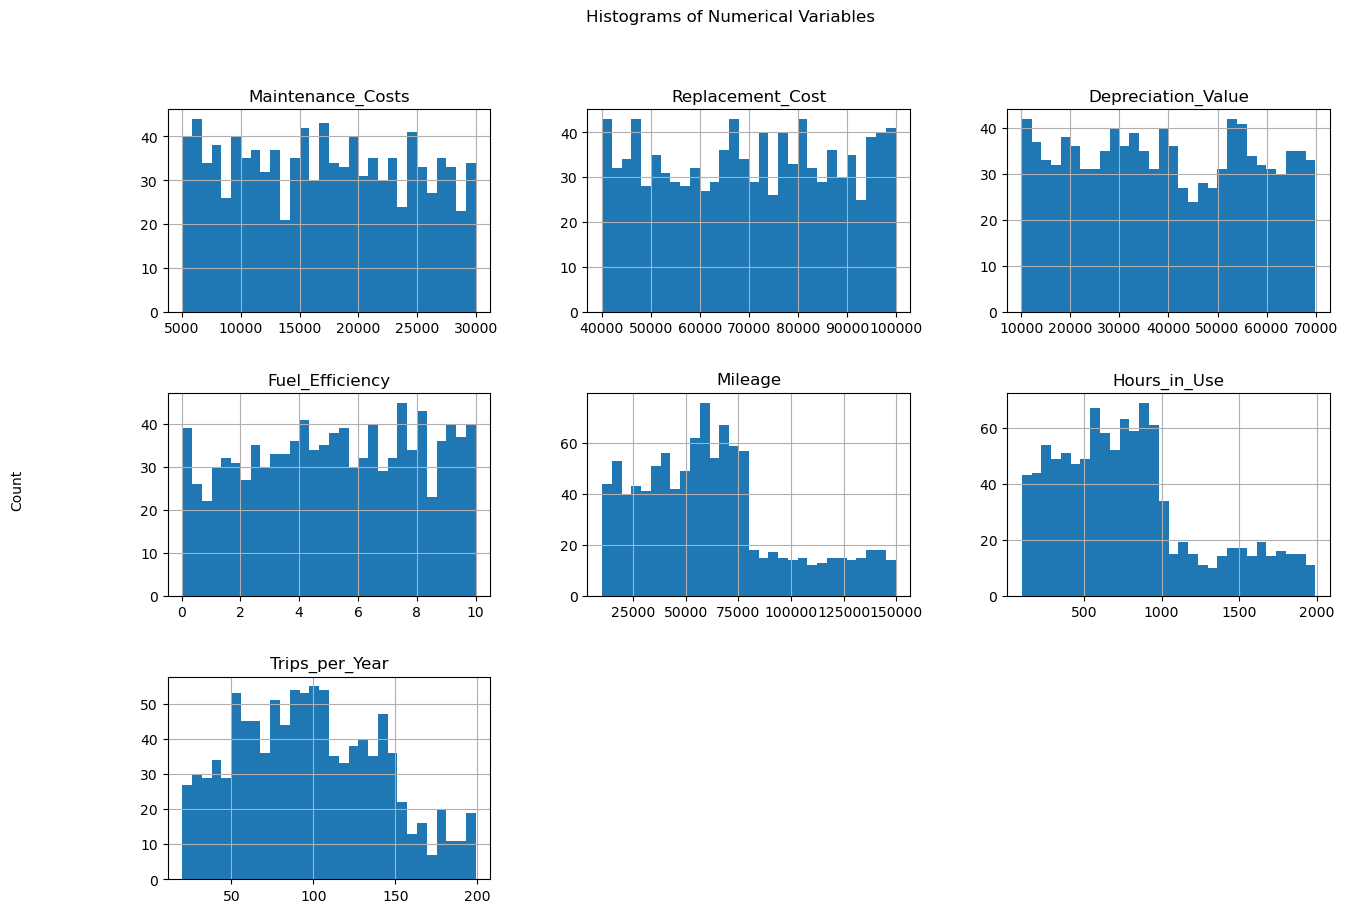

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame containing only the numeric columns
numeric_columns

# Plot histograms for all numerical columns
fig = df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Variables')

# Set the label for the entire figure
plt.gcf().text(0.02, 0.5, 'Count', va='center', rotation='vertical')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()

- Maintenance Costs: The distribution is relatively uniform across different values, with no significant skewness or concentration in a particular range. This suggests that maintenance costs are spread out fairly evenly across the fleet.
- Replacement Cost: The distribution shows a gradual increase in the number of records as the replacement cost rises, with a peak near the higher end. This could indicate that many vehicles in the fleet have a higher replacement cost, possibly due to the inclusion of newer or more expensive vehicles.
- Depreciation Value: The distribution appears uniform across the depreciation values, which may suggest that the vehicles are depreciating at a consistent rate or are of similar age and value.
- Fuel Efficiency: The histogram shows a wide range of fuel efficiency values, with a noticeable number of vehicles having lower efficiency (close to 0), which might indicate potential issues with these vehicles or that they are used in less fuel-efficient conditions.
- Mileage: The mileage distribution shows a peak around the mid-range (50,000 to 75,000 miles) and then tapers off. This suggests that a large portion of the fleet has moderate mileage, with fewer vehicles in either the very low or very high mileage ranges.
- Hours in Use: The histogram shows that most vehicles have been used between 500 to 1000 hours, with fewer vehicles showing very high usage. This could indicate a standard usage pattern within the fleet, with only a few vehicles being outliers.
- Trips per Year: The distribution is relatively spread out, with a noticeable concentration around 50 to 150 trips per year. This suggests variability in how frequently vehicles are used, with some vehicles being used very frequently while others are less utilized.

General Insights:

- The variability in distributions suggests that the fleet has diverse usage patterns, with some vehicles being more heavily used or costly to maintain than others.
- Identifying the outliers in variables like Mileage, Hours in Use, and Fuel Efficiency could be crucial for optimizing fleet management and addressing underutilization or overutilization.
- The even spread of maintenance and depreciation values may imply a well-maintained fleet, though the presence of some vehicles with low fuel efficiency might need attention.

These insights can guide further analysis, such as correlating these variables with vehicle type, department, or specific time periods to understand better the factors influencing these distributions.

# Categorical variables 

In [20]:
# DataFrame containing only the categorical variables 
import pandas as pd

# Assuming df is your DataFrame
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_df = df[categorical_columns]

# Display the categorical variables
print("Categorical Variables:")
print(categorical_df.head())

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 22, Finished, Available, Finished)

Categorical Variables:
     Asset_ID         Asset_Type Purchase_Date Lifecycle_Status Fuel_Type  \
0  ASSET_0001  Special Equipment    2017-01-16      End of Life  Gasoline   
1  ASSET_0005  Special Equipment    2019-10-21      End of Life  Gasoline   
2  ASSET_0007  Special Equipment    2022-07-14      End of Life    Diesel   
3  ASSET_0009  Special Equipment    2011-12-02       In Service    Diesel   
4  ASSET_0010  Special Equipment    2014-12-30       In Service    Diesel   

           Department  
0  Emergency Services  
1      Transportation  
2  Emergency Services  
3        Public Works  
4      Transportation  


# Distribution of categorical variables 

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 23, Finished, Available, Finished)

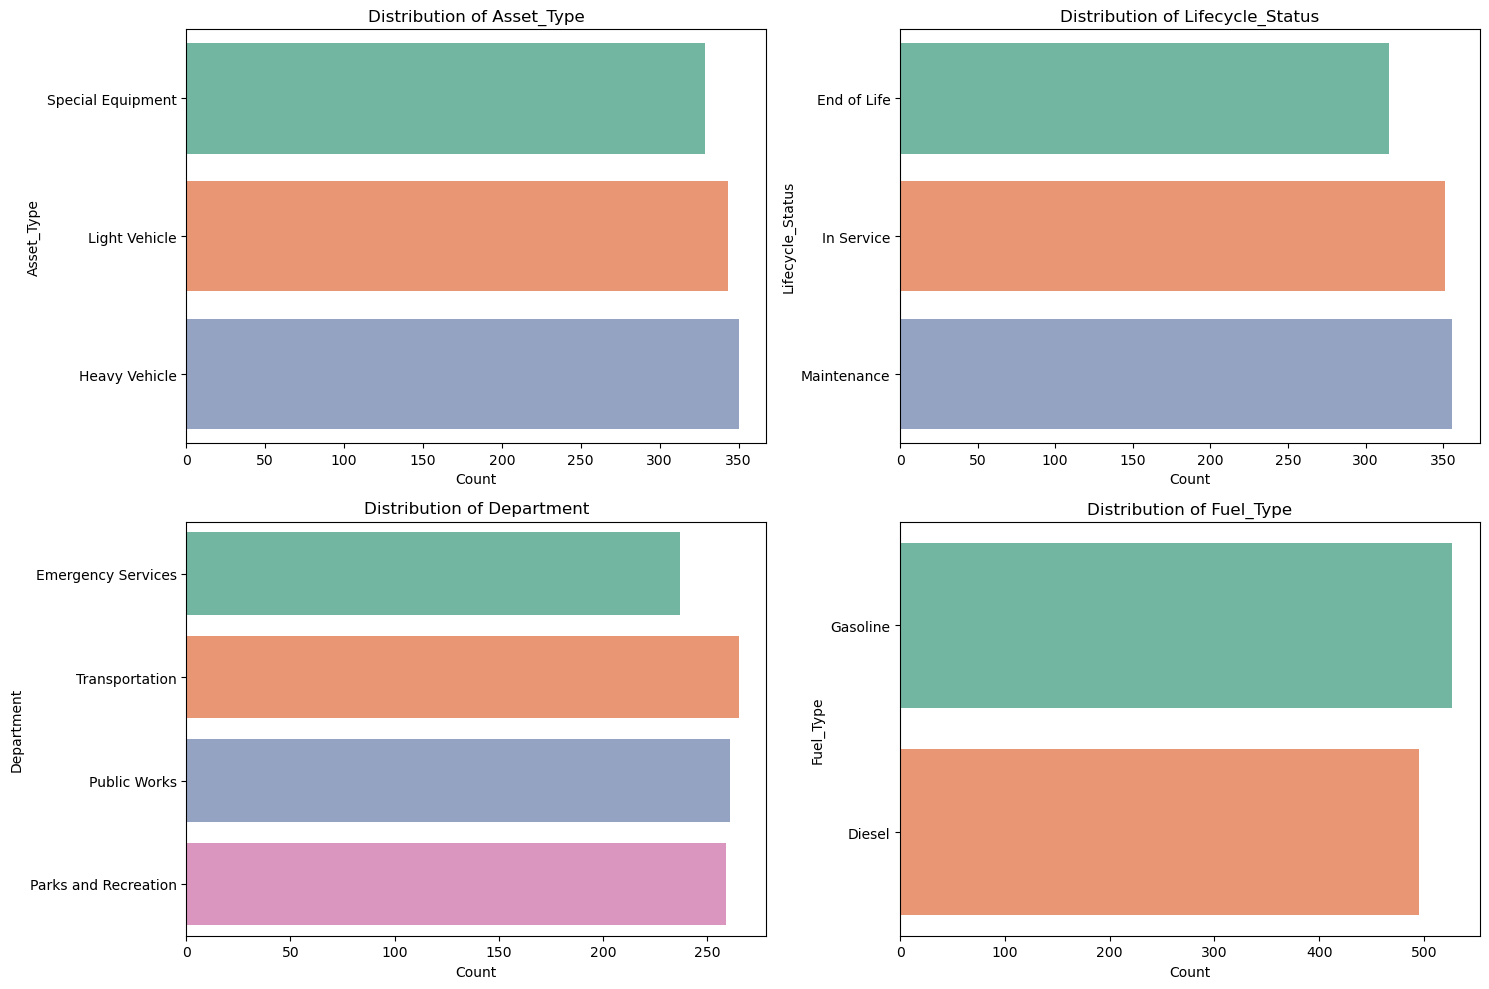

In [21]:
# selected categorical columns
selected_categorical_columns = ['Asset_Type', 'Lifecycle_Status', 'Department', 'Fuel_Type']

import matplotlib.pyplot as plt
import seaborn as sns

#  DataFrame containing the categorical columns
selected_categorical_columns = ['Asset_Type', 'Lifecycle_Status', 'Department', 'Fuel_Type']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Iterate over each selected categorical column and plot its distribution
for i, column in enumerate(selected_categorical_columns, 1):
    plt.subplot(2, 2, i)  # Create a subplot for each categorical column
    sns.countplot(y=df[column], palette='Set2')  # Use a horizontal count plot for better readability
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# Insights
- Asset Type Distribution:The distribution shows that there is a relatively balanced representation of different asset types in the dataset, with Heavy Vehicles being the most common, followed by Light Vehicles, and then Special Equipment.
- Lifecycle Status Distribution: The vehicles in the dataset are categorized into three lifecycle statuses: In Service, Maintenance, and End of Life. The distribution is fairly balanced, with a slightly higher number of vehicles in the In Service category. This suggests that a significant portion of the fleet is still actively being used, while a smaller portion is either under maintenance or has reached the end of its life cycle.
- Department Distribution: The assets are distributed across several departments, with Parks and Recreation and Public Works having the most vehicles, followed by Transportation and Emergency Services. This distribution might reflect the specific needs and responsibilities of each department in managing city operations.
- Fuel Type Distribution: The dataset indicates that the fleet predominantly uses two types of fuel: Gasoline and Diesel. Gasoline is the most common fuel type, followed by Diesel. This distribution might be influenced by the types of vehicles in the fleet and the operational requirements of different departments.

These insights are useful for understanding the composition of the fleet, planning maintenance schedules, budgeting for fuel and replacement parts, and optimizing asset allocation across departments.

# Distribution of Maintenance_Costs, Replacement_Cost, Depreciation_Value versus Asset_Type

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 24, Finished, Available, Finished)

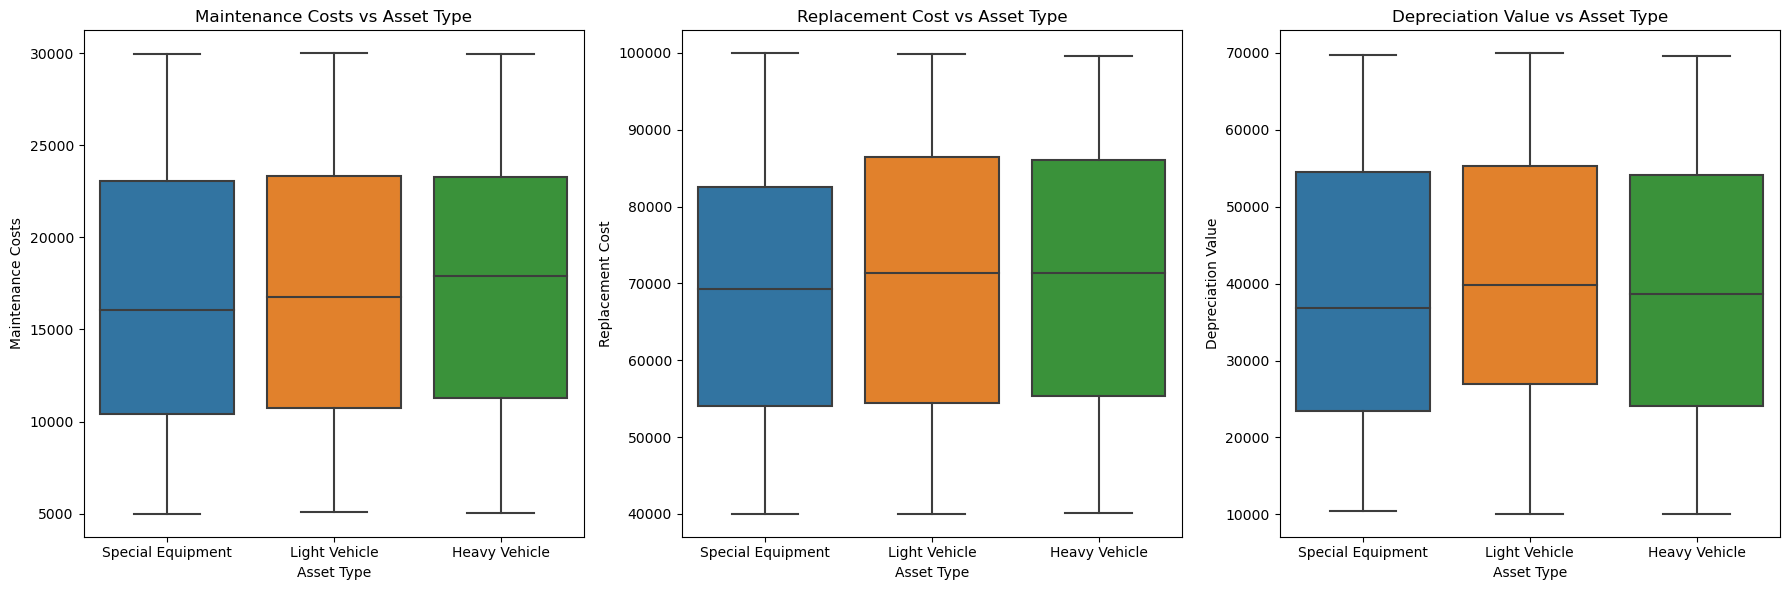

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Maintenance Costs vs Asset Type
sns.boxplot(x='Asset_Type', y='Maintenance_Costs', data=df, ax=axs[0])
axs[0].set_title('Maintenance Costs vs Asset Type')
axs[0].set_ylabel('Maintenance Costs')
axs[0].set_xlabel('Asset Type')

# Plot Replacement Cost vs Asset Type
sns.boxplot(x='Asset_Type', y='Replacement_Cost', data=df, ax=axs[1])
axs[1].set_title('Replacement Cost vs Asset Type')
axs[1].set_ylabel('Replacement Cost')
axs[1].set_xlabel('Asset Type')

# Plot Depreciation Value vs Asset Type
sns.boxplot(x='Asset_Type', y='Depreciation_Value', data=df, ax=axs[2])
axs[2].set_title('Depreciation Value vs Asset Type')
axs[2].set_ylabel('Depreciation Value')
axs[2].set_xlabel('Asset Type')

# Adjust layout to avoid overlapping titles/labels
plt.tight_layout()
plt.show()

# Insights
- Maintenance Costs: Consistency Across Asset Types: The median maintenance costs are similar across Special Equipment, Light Vehicles, and Heavy Vehicles. This suggests that maintenance practices and costs are relatively standardized across the different asset types within the fleet.
- Higher Variability in Special Equipment: The wider range of maintenance costs for Special Equipment indicates that some assets in this category may require significantly more maintenance than others, which could be due to the specialized nature of the equipment.
- Replacement Costs: Uniformity in Replacement Costs: The replacement costs are consistent across all asset types, with similar medians and ranges. This implies that the cost of replacing assets is relatively stable, regardless of whether the asset is a Light Vehicle, Heavy Vehicle, or Special Equipment.
- Possible Predictability: The uniform replacement costs could make it easier for the fleet management team to budget for asset replacements, as there are no significant cost outliers across different asset types.
- Depreciation Value: Significant Variation: There is a noticeable variation in depreciation values, especially in Heavy Vehicles and Light Vehicles. This could suggest that some assets within these categories are depreciating faster than others, potentially due to higher usage, age, or differences in initial value.
- Special Equipment Stability: Special Equipment shows a more stable depreciation value compared to the other asset types. This might indicate that these assets are either newer or better maintained, leading to more predictable depreciation.

Key Takeaways:
- Standardization: The uniformity in maintenance and replacement costs suggests effective cost management across different asset types.
- Focus Areas: The variability in depreciation, particularly in Heavy Vehicles, may require further investigation to understand the underlying causes, such as differences in usage patterns or maintenance quality.
- Budgeting and Forecasting: The insights into replacement costs and depreciation can help in more accurate budgeting and forecasting for asset lifecycle management, ensuring that the fleet remains cost-effective and operationally efficient.

These insights can guide decision-making in areas like maintenance scheduling, asset replacement, and financial planning for the City of Toronto’s fleet management.

# Fuel_Efficiency vs Fuel_Type

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 25, Finished, Available, Finished)

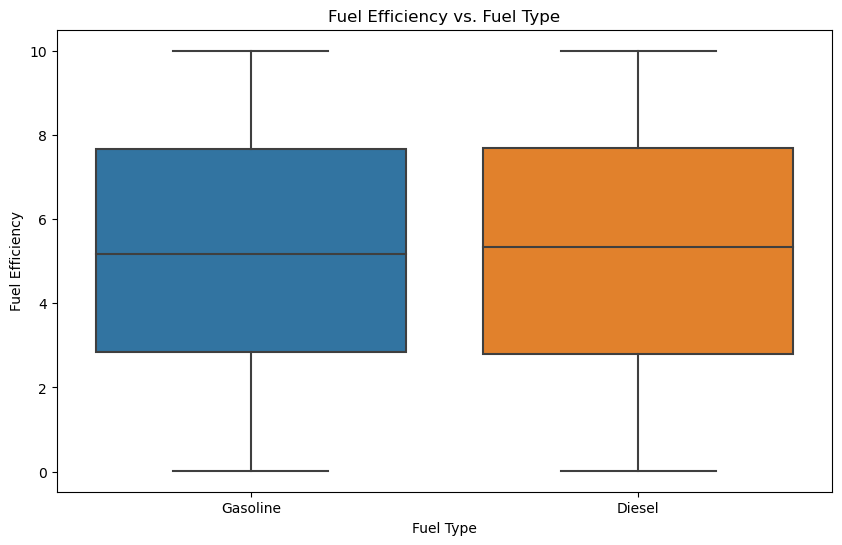

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for Fuel_Efficiency vs. Fuel_Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel_Type', y='Fuel_Efficiency', data=df)

# Set the title and labels
plt.title('Fuel Efficiency vs. Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Efficiency')

# Display the plot
plt.show()

# Insight
Overall, the fuel efficiency distribution between gasoline and diesel vehicles is quite similar. This suggests that both fuel types are performing similarly in terms of efficiency, at least within the fleet under consideration.



#### Fuel_Efficiency vs Fuel_Type, Mileage vs Lifecycle_Status, Department vs Hours_in_Use and Department vs Trips_per_Year

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 26, Finished, Available, Finished)

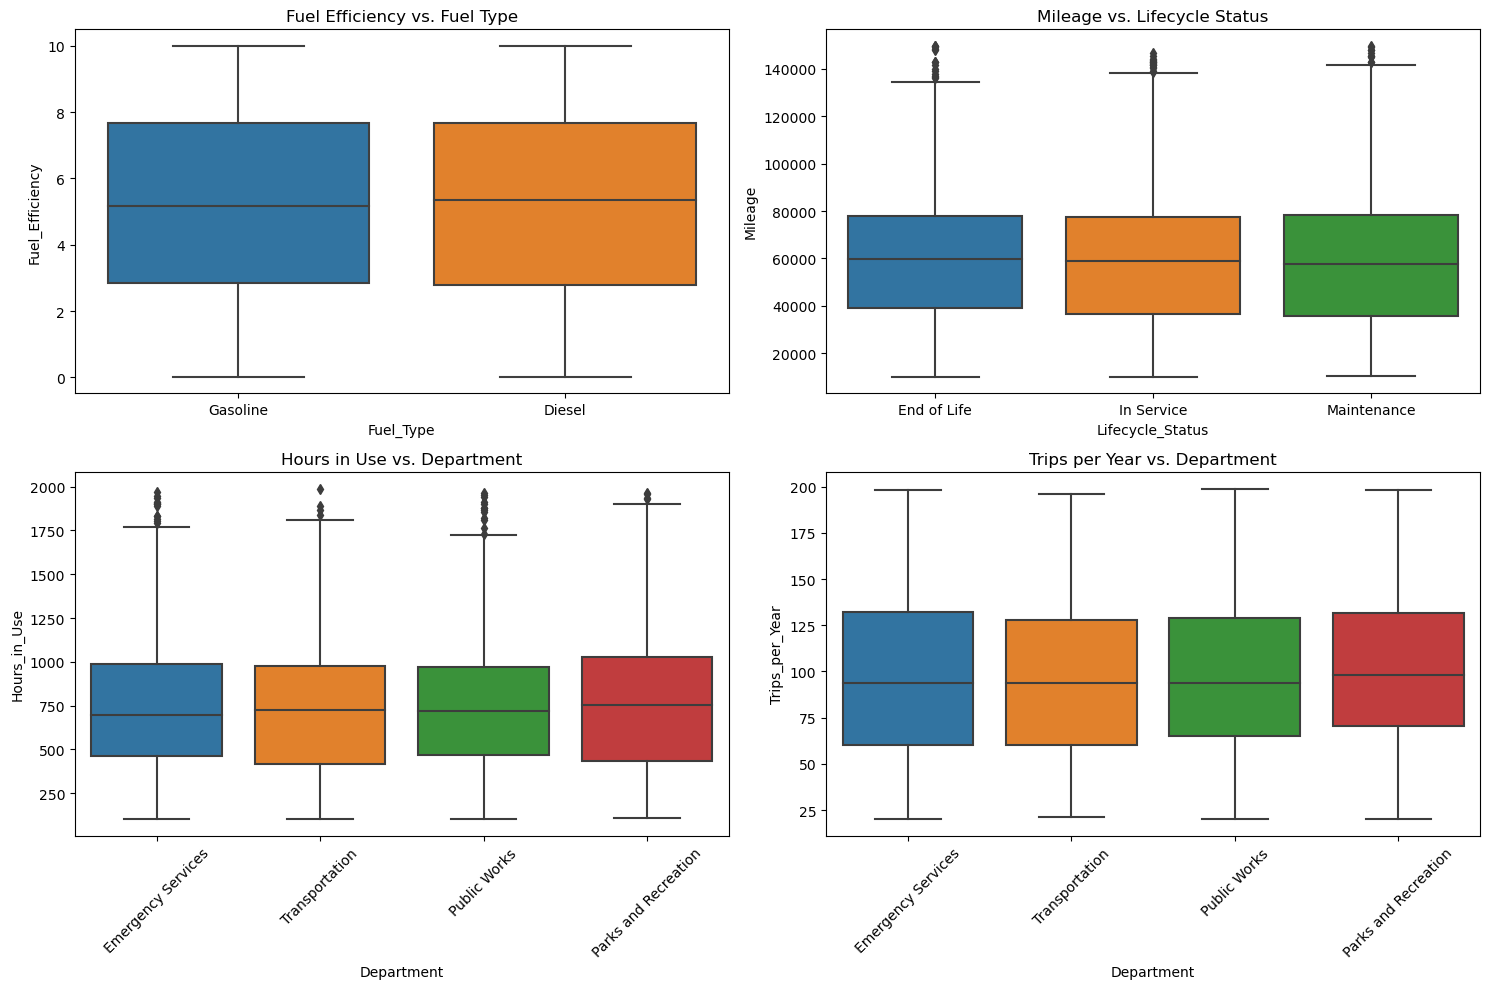

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot Fuel_Efficiency vs. Fuel_Type
plt.subplot(2, 2, 1)
sns.boxplot(x='Fuel_Type', y='Fuel_Efficiency', data=df)
plt.title('Fuel Efficiency vs. Fuel Type')

# Plot Mileage vs. Lifecycle_Status
plt.subplot(2, 2, 2)
sns.boxplot(x='Lifecycle_Status', y='Mileage', data=df)
plt.title('Mileage vs. Lifecycle Status')

# Plot Hours_in_Use vs. Department
plt.subplot(2, 2, 3)
sns.boxplot(x='Department', y='Hours_in_Use', data=df)
plt.title('Hours in Use vs. Department')
plt.xticks(rotation=45)

# Plot Trips_per_Year vs. Department
plt.subplot(2, 2, 4)
sns.boxplot(x='Department', y='Trips_per_Year', data=df)
plt.title('Trips per Year vs. Department')
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Insights
- Fuel Efficiency vs. Fuel Type: Both gasoline and diesel vehicles show similar ranges in fuel efficiency. There is no significant difference in the median fuel efficiency between gasoline and diesel vehicles.
- Mileage vs. Lifecycle Status: Vehicles marked as “In Service” and “Maintenance” have a similar distribution of mileage. Vehicles in the “End of Life” category tend to have lower mileage, with fewer high-mileage outliers, indicating that high mileage could be a factor in moving vehicles to the end-of-life category.
- Hours in Use vs. Department: Emergency Services and Transportation departments show a wider range of hours in use, with several vehicles being heavily used (high outliers). Parks and Recreation have a more consistent usage pattern with fewer high-hour outliers.
- Trips per Year vs. Department: All departments exhibit a similar distribution of trips per year, with most vehicles performing around 75-125 trips annually. No department stands out significantly in terms of higher or lower trip frequencies, indicating a fairly balanced workload across departments.

These insights suggest a generally consistent performance across different departments and vehicle types, with some variability in usage and mileage that could be explored further for optimization and efficiency improvements.

### Lifecycle_status vs Asset_Type, Department vs Asset_Type, Department vs Fuel_Type

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 27, Finished, Available, Finished)

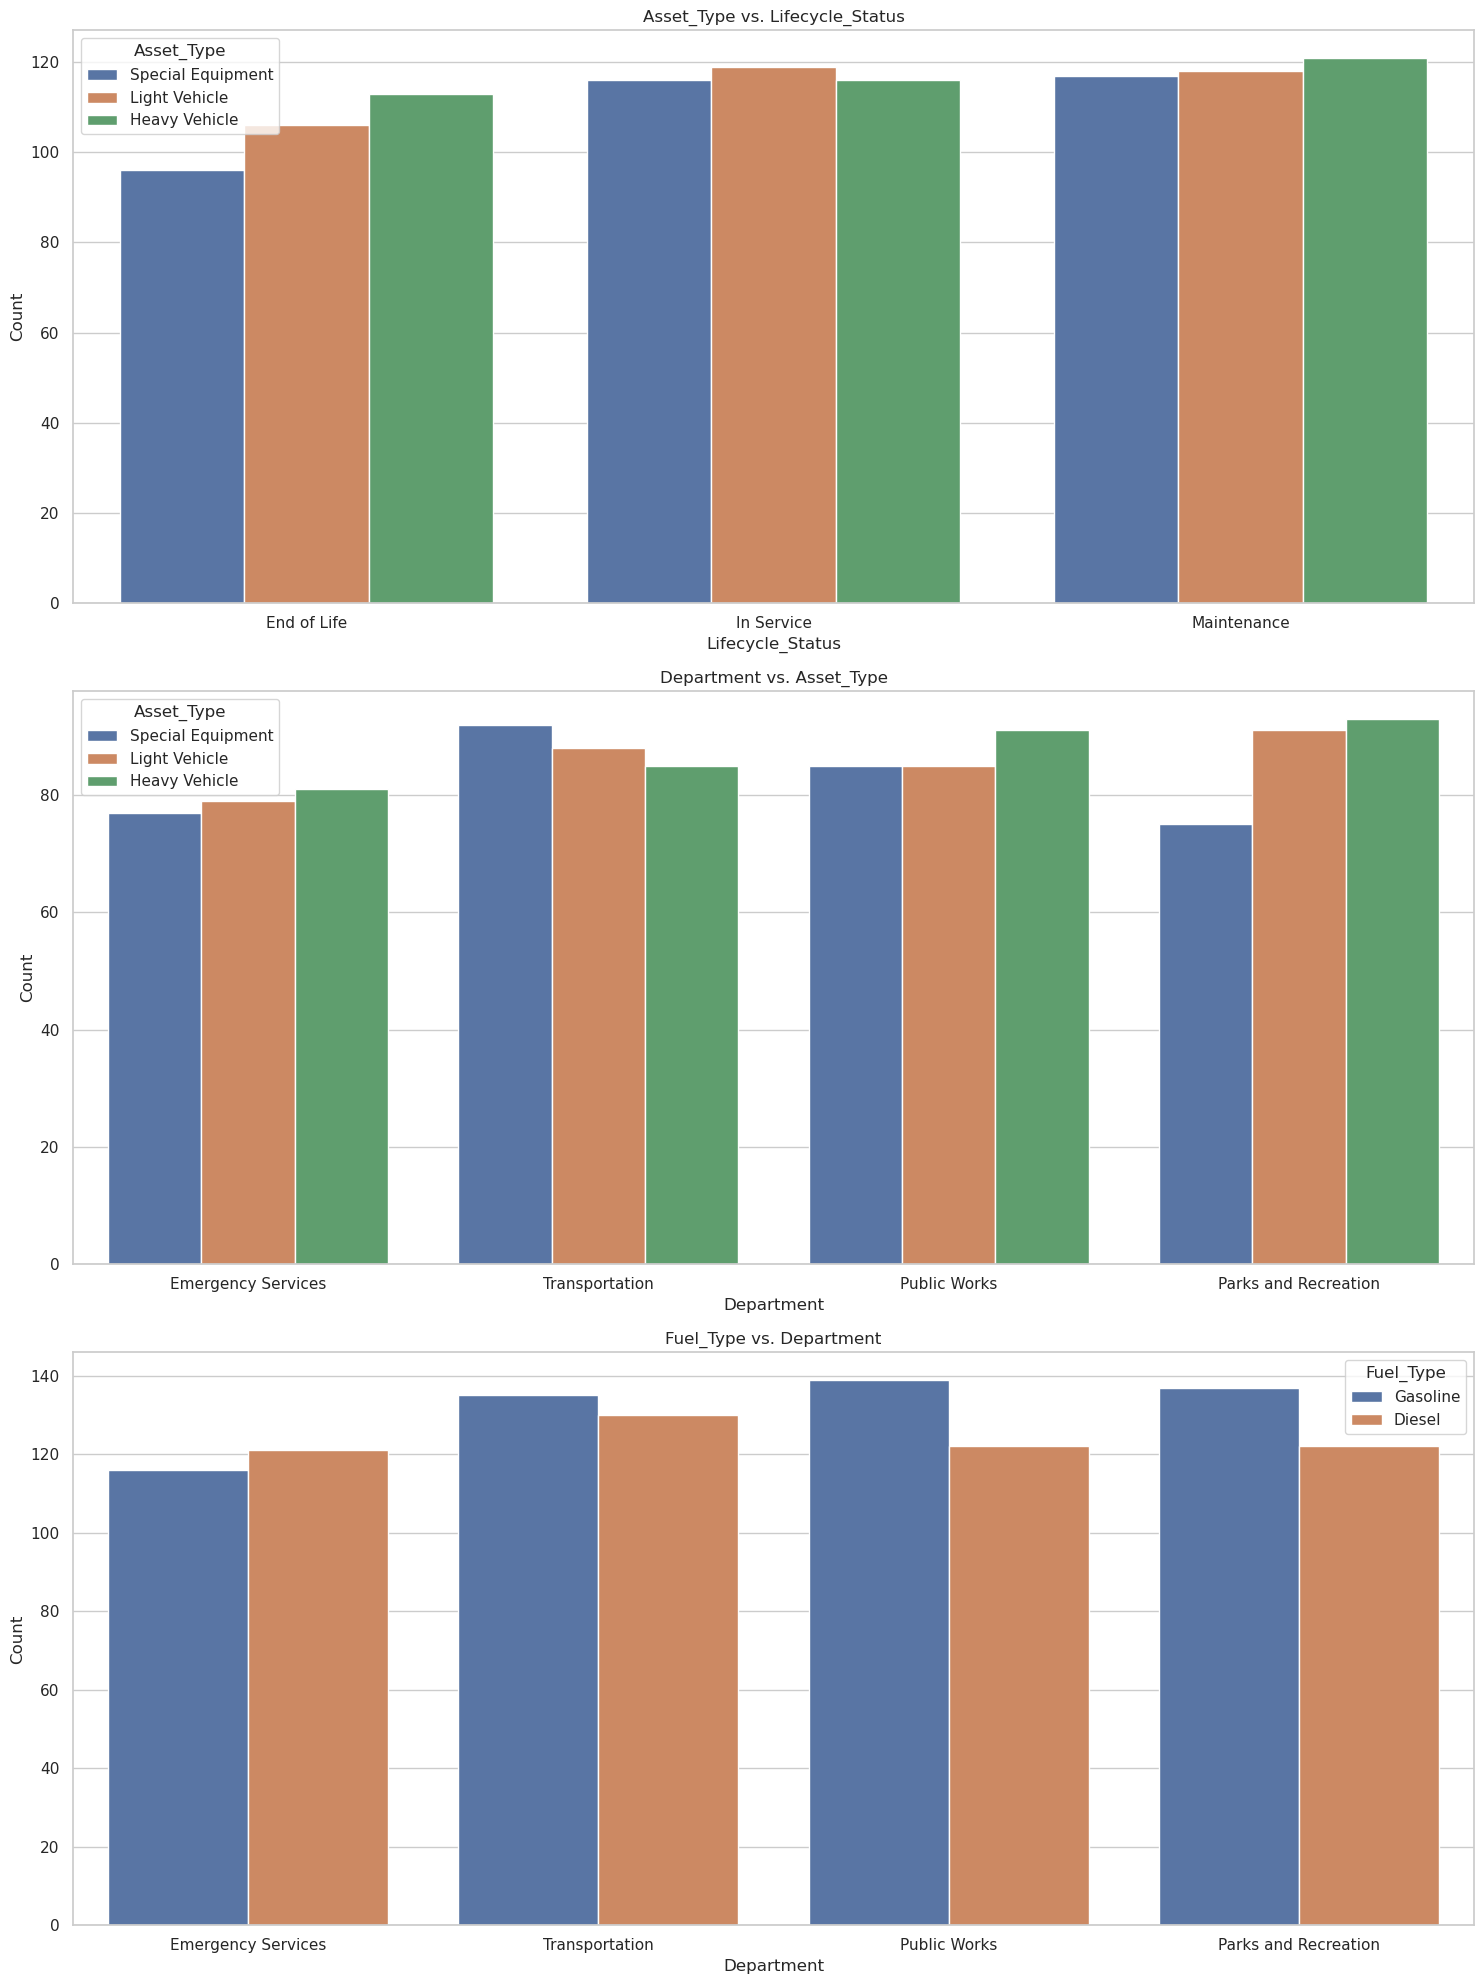

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

# Plot Asset_Type vs. Lifecycle_Status
sns.countplot(data=df, x='Lifecycle_Status', hue='Asset_Type', ax=axs[0])
axs[0].set_title('Asset_Type vs. Lifecycle_Status')
axs[0].set_xlabel('Lifecycle_Status')
axs[0].set_ylabel('Count')

# Plot Department vs. Asset_Type
sns.countplot(data=df, x='Department', hue='Asset_Type', ax=axs[1])
axs[1].set_title('Department vs. Asset_Type')
axs[1].set_xlabel('Department')
axs[1].set_ylabel('Count')

# Plot Fuel_Type vs. Department
sns.countplot(data=df, x='Department', hue='Fuel_Type', ax=axs[2])
axs[2].set_title('Fuel_Type vs. Department')
axs[2].set_xlabel('Department')
axs[2].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Insights
- Asset Type vs. Lifecycle Status: Across all lifecycle statuses (End of Life, In Service, and Maintenance), the distribution of asset types (Special Equipment, Light Vehicle, Heavy Vehicle) is quite balanced. This indicates that each type of asset is being utilized fairly consistently, regardless of its lifecycle stage.
- Department vs. Asset Type: Different departments have a fairly even distribution of asset types. Emergency Services and Public Works departments appear to have a slightly higher number of Heavy Vehicles compared to other departments, possibly reflecting the specific needs of those departments. Light Vehicles are used consistently across all departments, showing their versatility.
- Fuel Type vs. Department:  The distribution of Fuel Type (Gasoline, Diesel) is quite even across all departments. There is no significant department that favors one fuel type over the other, indicating a balanced usage of fuel types in the fleet.

These visualizations suggest a balanced distribution of assets and fuel types across departments, and a consistent utilization pattern of assets across their lifecycle stages. This could imply that the fleet is being managed in a standardized way across different departments and asset types.

### Maintenance_Costs vs Mileage, Maintenance_Costs vs Fuel_Efficiency, Depreciation_Value vs Replacement_Cost

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 28, Finished, Available, Finished)

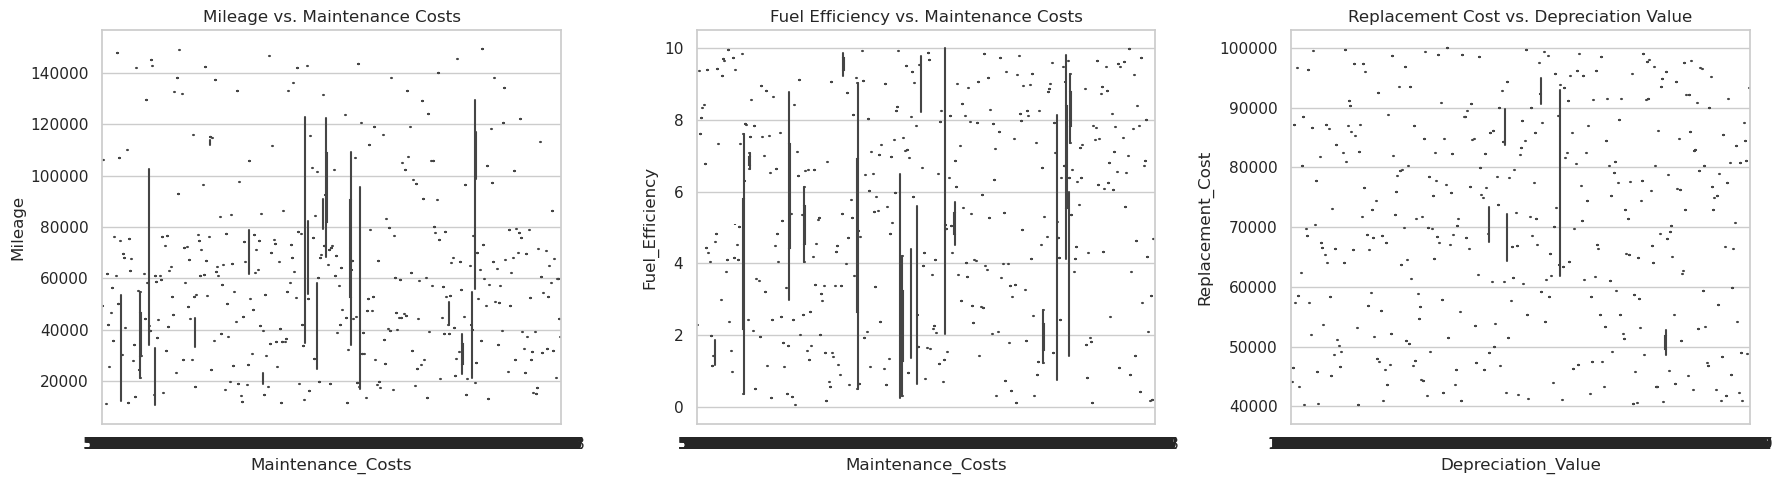

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

# Mileage vs. Maintenance Costs
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='Maintenance_Costs', y='Mileage')
plt.title('Mileage vs. Maintenance Costs')

# Fuel Efficiency vs. Maintenance Costs
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Maintenance_Costs', y='Fuel_Efficiency')
plt.title('Fuel Efficiency vs. Maintenance Costs')

# Replacement Cost vs. Depreciation Value
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Depreciation_Value', y='Replacement_Cost')
plt.title('Replacement Cost vs. Depreciation Value')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Insights
- Mileage vs. Maintenance Costs: Observation: The distribution of mileage appears quite spread out across all levels of maintenance costs. There are clusters of vehicles with lower mileage that incur a wide range of maintenance costs, and a similar pattern can be observed with higher mileage vehicles.
- Insight: The relationship between mileage and maintenance costs does not show a clear trend. The distribution indicates that both high and low mileage vehicles can have either low or high maintenance costs, suggesting that mileage alone may not be a strong predictor of maintenance expenses.
- Fuel Efficiency vs. Maintenance Costs: Observation: Fuel efficiency also shows a wide distribution across various maintenance cost levels. There doesn’t seem to be a distinct pattern that ties fuel efficiency directly to maintenance costs. Insight: Similar to mileage, fuel efficiency is not tightly correlated with maintenance costs. Vehicles with varying levels of fuel efficiency incur similar maintenance costs, implying that factors other than fuel efficiency might be more influential in determining maintenance expenditures.
- Replacement Cost vs. Depreciation Value: Observation: The replacement cost for vehicles shows variability across different levels of depreciation value, but with some concentration around certain replacement cost ranges. Insight: There seems to be a broader range of replacement costs at higher depreciation values, suggesting that vehicles with higher depreciation might require more significant replacement costs. However, the variability within each depreciation category implies that replacement costs are influenced by multiple factors, not just depreciation.

## Hours_in_Use versus Asset_Type to identify underutilized and overutilized vehicles:

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 29, Finished, Available, Finished)

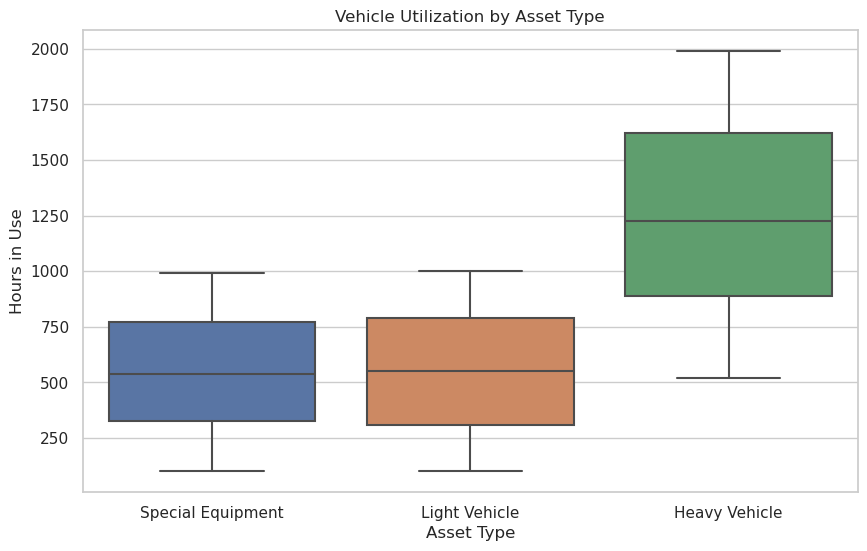

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Boxplot to identify underutilized and overutilized vehicles by Asset_Type
sns.boxplot(data=df, x='Asset_Type', y='Hours_in_Use')

# Add title and labels
plt.title('Vehicle Utilization by Asset Type')
plt.xlabel('Asset Type')
plt.ylabel('Hours in Use')

# Display the plot
plt.show()

- Special Equipment: This asset type generally has lower utilization, with the median hours in use around 500 hours. The interquartile range (IQR) is narrow, indicating that most vehicles within this category have a similar usage level. There are no significant outliers, suggesting consistent usage across vehicles.
- Light Vehicle: Light vehicles also show relatively low utilization, with the median hours in use slightly below 500 hours. The IQR is similar to that of special equipment, indicating consistent usage within this category as well. There are no extreme outliers, which implies uniform usage patterns across light vehicles.
- Heavy Vehicle: Heavy vehicles have the highest utilization, with a median close to 1250 hours. The IQR is broader, indicating greater variability in usage within this category. The range extends higher compared to the other asset types, suggesting that some heavy vehicles are utilized significantly more than others. However, there are no extreme outliers, indicating that the high utilization is relatively consistent across heavy vehicles.

Key Insight:

Heavy Vehicles are more intensively used compared to Special Equipment and Light Vehicles.
The consistent distribution of utilization within each asset type suggests that there are no extreme cases of underutilization or overutilization within each category, although heavy vehicles are generally used more extensively.

### Vehicle Utilization by Department

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 30, Finished, Available, Finished)

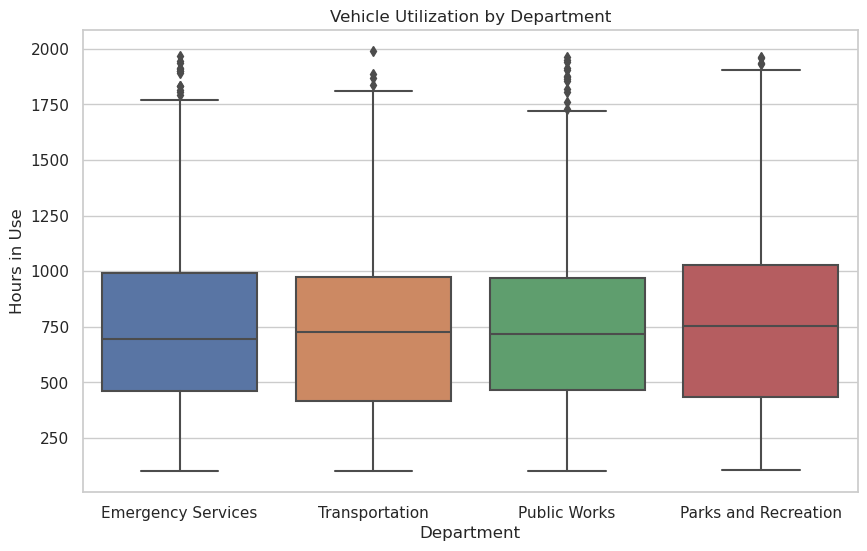

In [28]:
# Boxplot to identify underutilized and overutilized vehicles by Department
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Department', y='Hours_in_Use')

# Add title and labels
plt.title('Vehicle Utilization by Department')
plt.xlabel('Department')
plt.ylabel('Hours in Use')

# Display the plot
plt.show()

# Insights
- Emergency Services:Median hours in use are around 750, with a broad interquartile range (IQR) indicating variability in vehicle usage. There are several outliers close to the maximum usage level, suggesting that a few vehicles in this department are utilized much more extensively than others.
- Transportation: Median hours in use are lower than Emergency Services, around 650 hours.
The IQR is narrow compared to other departments, indicating more consistent usage of vehicles within the Transportation department.
There are fewer outliers, indicating more uniform utilization across vehicles in this department.
- Public Works: The median usage is similar to that of the Transportation department, but there is a wider range of vehicle utilization. Numerous outliers are present, indicating that while most vehicles are consistently utilized, some are either heavily overused or underused.
- Parks and Recreation: The median hours in use are higher than in Transportation and Public Works, closer to 800 hours. The IQR is broad, showing a wide variation in vehicle usage within this department. There are a few outliers, suggesting that some vehicles are either underutilized or overutilized.

Key Insights:

- Variability: There’s significant variability in vehicle utilization within and across departments, with Public Works and Emergency Services showing the widest ranges and the most outliers, indicating inconsistent vehicle usage.
- Outliers: Emergency Services and Public Works have the most outliers, suggesting that certain vehicles are either highly overused or underutilized compared to the majority.
- Median Utilization: Parks and Recreation has the highest median utilization, followed by Emergency Services, while Transportation has the lowest median usage. This may reflect different operational demands across these departments.


# Asset Utilisation rate 
The utilization rate is a metric that indicates how effectively assets (vehicles) are being used. It’s often expressed as a percentage

# Why we need it!
- Fleet Optimization: Identify underutilized or overutilized vehicles.
- Resource Allocation: Adjust fleet size or reassign vehicles based on utilization rates.
- Cost Management: Ensure vehicles are not over or underutilized to optimize maintenance and operational costs.


In [29]:
#  Lets assume a full year availability 
total_available_hours = 365 * 24  # 8760 hours in a year

# Calculate utilization rate
df['Utilization_Rate (%)'] = (df['Hours_in_Use'] / total_available_hours) * 100

# Display the updated DataFrame with Utilization Rate
df[['Asset_Type', 'Hours_in_Use', 'Utilization_Rate (%)']].head()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 31, Finished, Available, Finished)

Asset_Type  Hours_in_Use  Utilization_Rate (%)
0  Special Equipment           307              3.504566
1  Special Equipment           237              2.705479
2  Special Equipment           636              7.260274
3  Special Equipment           672              7.671233
4  Special Equipment           640              7.305936

# Visualise asset utilisation rate

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 32, Finished, Available, Finished)

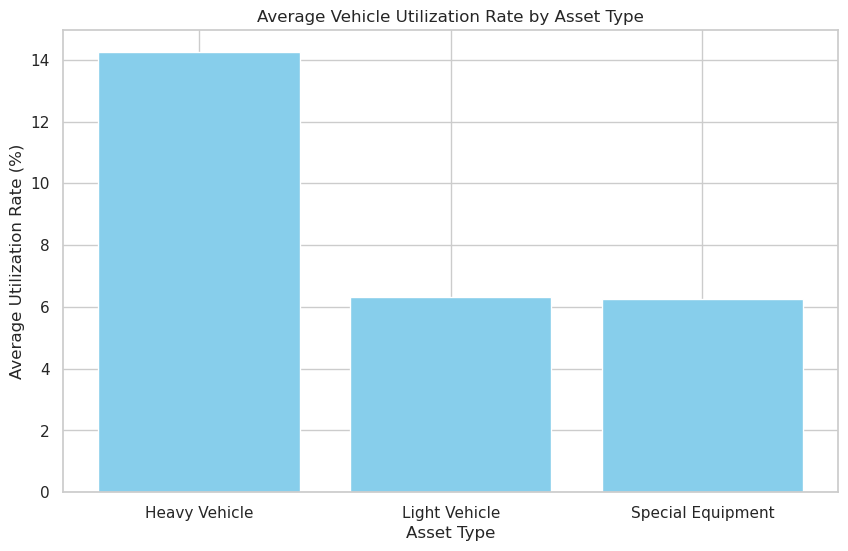

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average utilization rate by Asset Type
average_utilization = df.groupby('Asset_Type')['Utilization_Rate (%)'].mean().reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(average_utilization['Asset_Type'], average_utilization['Utilization_Rate (%)'], color='skyblue')

# Set plot title and labels
plt.title('Average Vehicle Utilization Rate by Asset Type')
plt.xlabel('Asset Type')
plt.ylabel('Average Utilization Rate (%)')

# Display the plot
plt.show()

# Key insights 

- Utilization Rate Variation: The utilization rate for the “Special Equipment” asset type varies significantly, ranging from approximately 2.7% to 7.7%. This suggests that not all special equipment assets are used equally, with some being underutilized compared to others.
- Lower Utilization: The lowest utilization rate is around 2.7%, associated with 237 hours in use. This indicates that some equipment may be sitting idle or not being deployed as efficiently as others.
- Higher Utilization: On the higher end, the utilization rate is about 7.7% with 672 hours in use, indicating that certain pieces of special equipment are being used much more frequently.
- Potential for Optimization: The wide range in utilization rates suggests a potential opportunity for optimizing the deployment and use of these assets. Some equipment could be redistributed or usage patterns could be analyzed to ensure more consistent utilization across the fleet.



StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 33, Finished, Available, Finished)

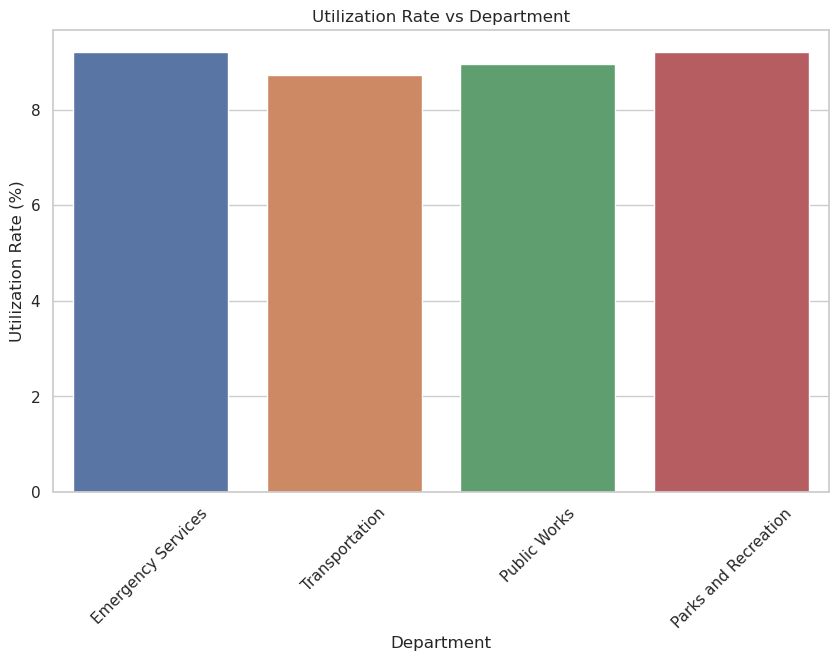

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'df' with the columns 'Department' and 'Utilization_Rate (%)'
plt.figure(figsize=(10, 6))

# Plotting a bar plot of Utilization Rate vs Department
sns.barplot(data=df, x='Department', y='Utilization_Rate (%)', errorbar=None)

# Setting the title and labels
plt.title('Utilization Rate vs Department')
plt.xlabel('Department')
plt.ylabel('Utilization Rate (%)')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Key insights
- Consistency Across Departments: The utilization rates across all departments (Emergency Services, Transportation, Public Works, and Parks and Recreation) appear to be quite consistent, with rates clustering around the same level, close to 8%.
- No Significant Outliers: There do not seem to be any significant outliers in utilization rates across the departments, suggesting that vehicle utilization is fairly uniform regardless of the department.
- Slight Variation: While the variation is minimal, Emergency Services and Parks and Recreation show slightly higher utilization rates compared to Transportation and Public Works. This might suggest that vehicles in Emergency Services and Parks and Recreation are more frequently used or are managed differently.
- Balanced Utilization: The overall similar levels of utilization indicate that the City of Toronto’s fleet management practices might be ensuring a balanced distribution of vehicle usage across different departments, which could be a positive indicator of efficient resource management.

This visualization suggests that there isn’t a significant disparity in how different departments utilize their vehicles, pointing towards an overall balanced fleet usage.


# Calculate asset Idle time
Idle Time = Total Available Operational Hours - Hours in Use



In [32]:
import pandas as pd

# Assuming df is your DataFrame and contains 'Hours_in_Use' and 'Asset_Type' columns

# Define the total available operational hours (for example, 720 hours in a month)
total_operational_hours = 720

# Calculate idle time
df['Idle_Time'] = total_operational_hours - df['Hours_in_Use']

# Display the first few records
print(df[['Asset_Type', 'Hours_in_Use', 'Idle_Time']])

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 34, Finished, Available, Finished)

             Asset_Type  Hours_in_Use  Idle_Time
0     Special Equipment           307        413
1     Special Equipment           237        483
2     Special Equipment           636         84
3     Special Equipment           672         48
4     Special Equipment           640         80
...                 ...           ...        ...
1017      Heavy Vehicle          1837      -1117
1018      Heavy Vehicle          1070       -350
1019      Heavy Vehicle          1189       -469
1020      Heavy Vehicle          1787      -1067
1021      Heavy Vehicle          1827      -1107

[1022 rows x 3 columns]


# Save the updated dataframe as delta table into the lakehouse

In [33]:
# Define the table name for the DataFrame
table_name = "updated_fleet_utilization_data"

# Let's save the data with processed columns to the lakehouse 
spark_df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 35, Finished, Available, Finished)

Spark dataframe saved to delta table: updated_fleet_utilization_data


### Distribution of Vehicle Idle_Time versus Asset_Type and Idle_Time versus Department

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 36, Finished, Available, Finished)

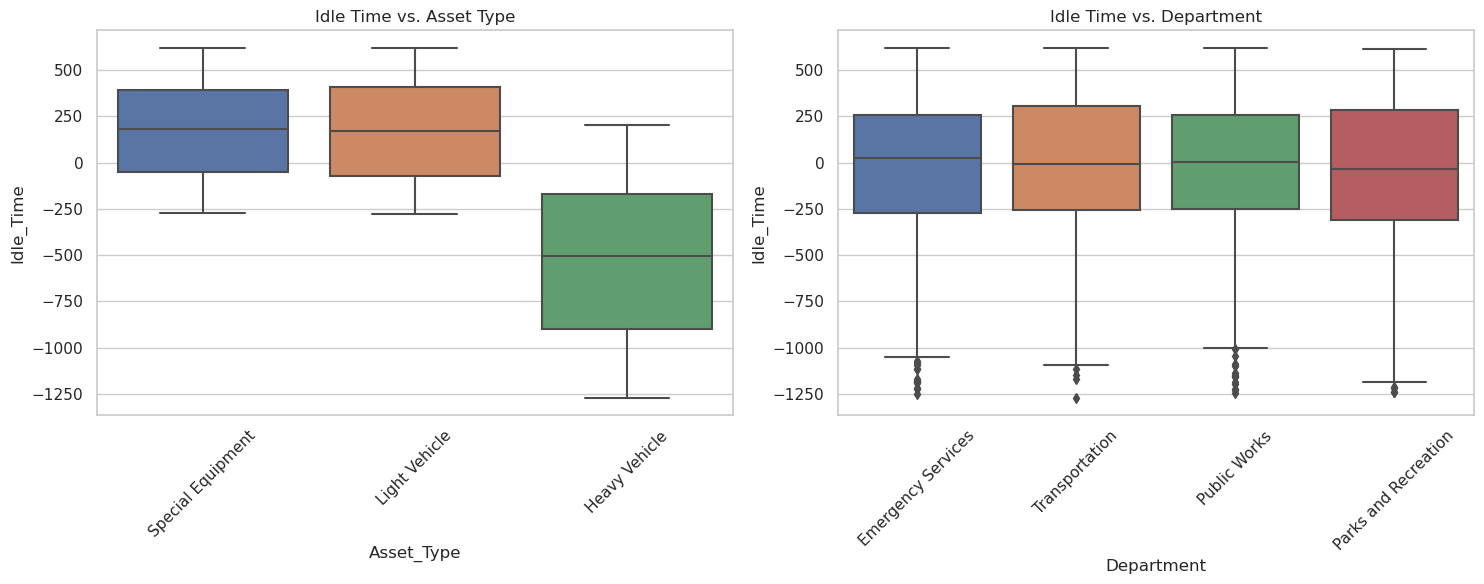

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Idle_Time', 'Asset_Type', and 'Department' columns are present

# Set up the matplotlib figure
plt.figure(figsize=(15, 6))

# Idle Time vs. Asset Type
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Asset_Type', y='Idle_Time')
plt.title('Idle Time vs. Asset Type')
plt.xticks(rotation=45)

# Idle Time vs. Department
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Department', y='Idle_Time')
plt.title('Idle Time vs. Department')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Insights
-Idle Time Across Asset Types:
Special Equipment and Light Vehicles have relatively higher median idle times compared to Heavy Vehicles.
Heavy Vehicles exhibit the widest range of idle times, with a lower median value, indicating that they are generally more utilized than the other asset types.
The box plot for Heavy Vehicles is more spread out, suggesting more variability in their utilization.
- Idle Time Across Departments: Emergency Services vehicles show the most variability in idle time, with a significant number of outliers indicating some vehicles are either underutilized or overutilized.
Public Works also has a notable number of outliers on the lower end, suggesting some vehicles might be heavily underutilized.
The median idle time is quite similar across all departments, but Parks and Recreation seems to have a slightly higher median idle time compared to others.

In general 

Heavy Vehicles are generally more utilized, while Special Equipment and Light Vehicles show higher idle times.
Emergency Services and Public Works departments have more variability in their vehicle idle times, indicating potential inefficiencies or inconsistencies in utilization.

This visualization highlights potential areas to investigate for improving fleet utilization, particularly for the departments and asset types with high idle times.

# What is the optimal number and type of vehicles needed to meet demand?

Optimal number and type of vehicles needed to meet demand based on the dataset we’ve been working on, we can proceed with the following steps using the data analysis we’ve conducted:

# 1. Utilization Rate Analysis:

From the data, we’ve calculated the utilization rate for different vehicle types and departments. For example, we found that Heavy Vehicles tend to have higher utilization rates compared to Light Vehicles and Special Equipment.


# 2. Departmental Analysis:

Emergency Services and Public Works departments show high utilization rates, indicating that these departments may require more vehicles or better maintenance schedules to meet demand effectively.
Departments like Parks and Recreation and Transportation also show significant utilization, but the rates are more balanced, suggesting the current fleet size might be adequate.

# 3. Vehicle Type Demand:

Heavy Vehicles show the highest utilization, suggesting that demand for these vehicles is higher. This may be due to the specific nature of tasks that require more robust vehicles, such as large-scale transportation or heavy-duty operations.
Light Vehicles and Special Equipment have lower utilization rates, which might suggest that either the fleet size is too large for current demand, or these vehicles are not being allocated efficiently.

# 4. Optimal Fleet Composition:

Increase Heavy Vehicles: Given their high utilization rates, it would be optimal to increase the number of heavy vehicles in the fleet, particularly in departments like Emergency Services and Public Works.
Maintain or Reduce Light Vehicles and Special Equipment: Since these categories show lower utilization, the fleet size in these categories could either be maintained at the current level or slightly reduced. If reduced, the freed resources could be reallocated to acquiring more heavy vehicles.

# 5. Utilization vs. Demand Matching:

Match Vehicle Types to Specific Department Needs: Emergency Services and Public Works should be prioritized for fleet expansion, especially with heavy vehicles. Conversely, for departments like Parks and Recreation, a balanced mix of vehicle types should be maintained, with no significant increase needed.
Seasonal Adjustments: Consider increasing the number of certain vehicles temporarily during peak seasons (e.g., snowplows during winter) to better meet demand.

# Based on the analysis:

Heavy Vehicles should be prioritized for expansion, especially in departments with higher demand like Emergency Services and Public Works.
Light Vehicles and Special Equipment show lower utilization, so their fleet sizes can either be maintained or slightly reduced.
Balanced Approach: A balanced approach to fleet management is crucial, with a focus on matching vehicle types with departmental needs and adjusting for seasonal demand.

This approach will ensure that the City of Toronto’s fleet is optimized to meet current and future demand effectively, reducing costs and improving operational efficiency.

# Depreciation and Lifecycle Analysis
We will explore how depreciation and lifecycle status relate to utilization and maintenance costs.

- 1. Depreciation vs. Utilization Rate: Analyze how the depreciation value of vehicles relates to their utilization rate. This can help identify if older or more depreciated vehicles are being utilized less or more than newer ones.

- 2. Depreciation vs. Maintenance Costs: Investigate the relationship between depreciation and maintenance costs to see if older or more depreciated vehicles incur higher maintenance costs.

- 3. Lifecycle Status vs. Utilization Rate: Compare the utilization rates across different lifecycle statuses (e.g., “In Service”, “End of Life”, “Maintenance”) to understand how vehicles at different lifecycle stages are being used.

- 4. Lifecycle Status vs. Maintenance Costs: Examine how maintenance costs vary across vehicles in different lifecycle statuses to determine if certain lifecycle stages are associated with higher maintenance expenses.




StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 37, Finished, Available, Finished)

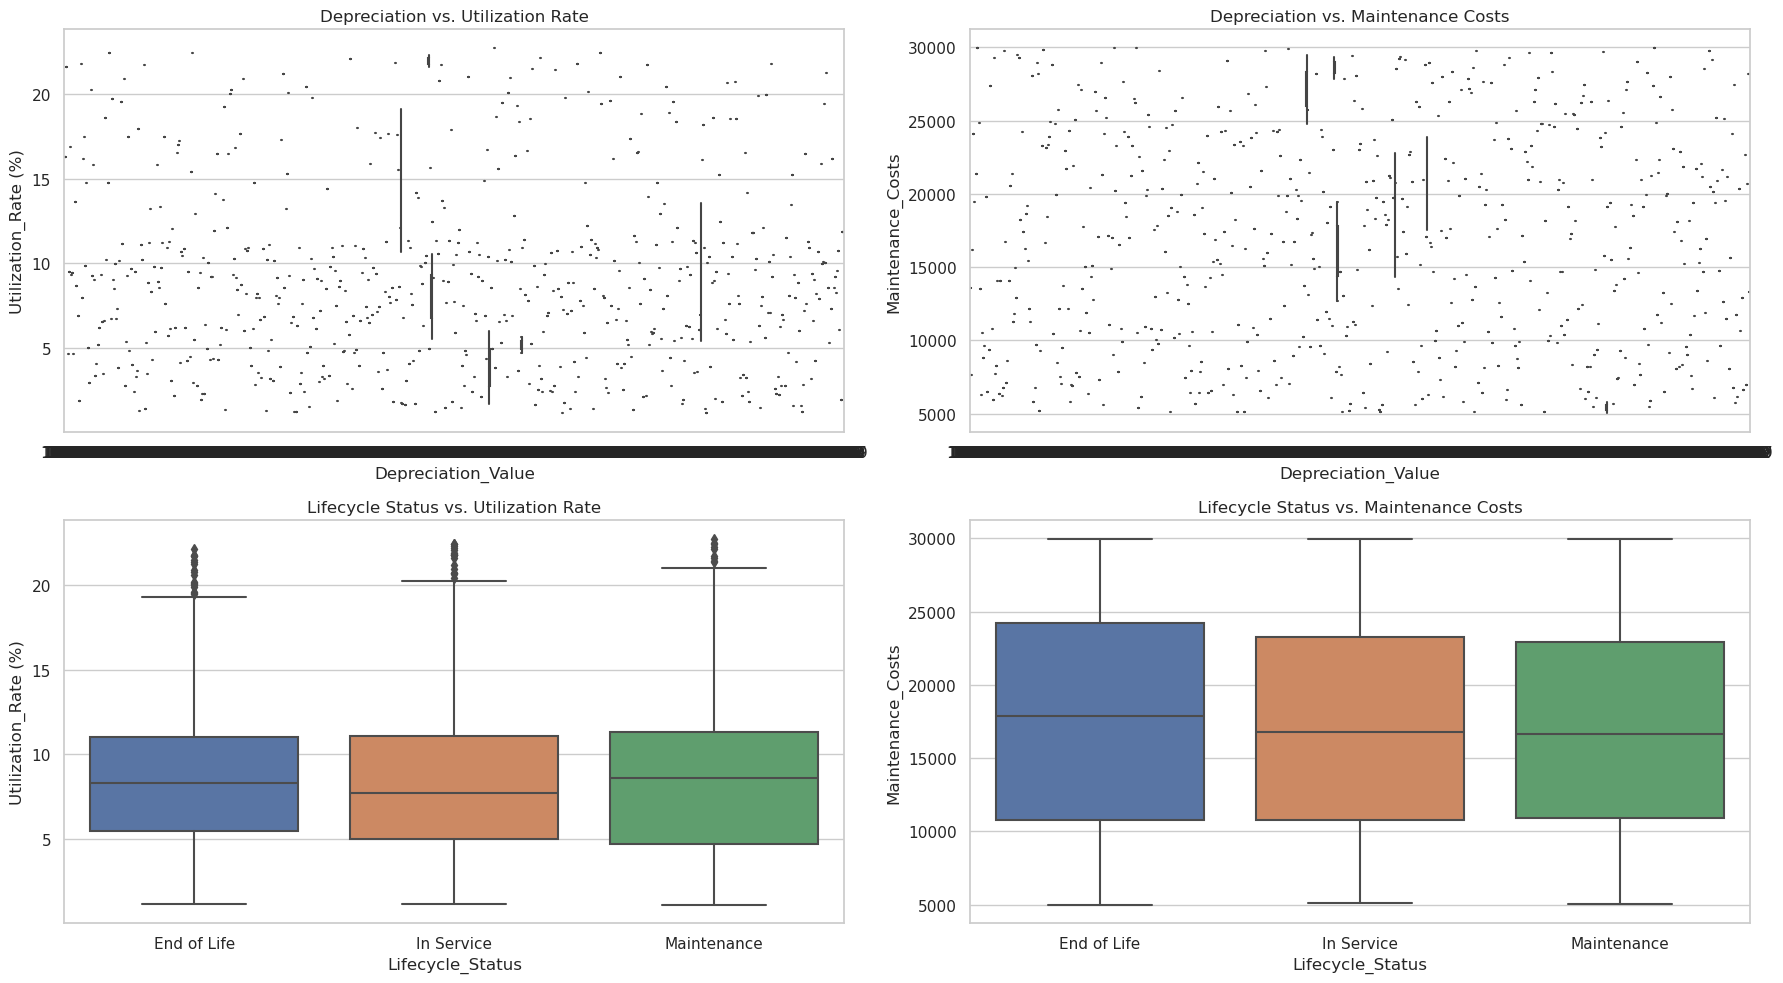

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Depreciation vs. Utilization Rate
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Depreciation_Value', y='Utilization_Rate (%)')
plt.title('Depreciation vs. Utilization Rate')

# Depreciation vs. Maintenance Costs
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Depreciation_Value', y='Maintenance_Costs')
plt.title('Depreciation vs. Maintenance Costs')

# Lifecycle Status vs. Utilization Rate
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Lifecycle_Status', y='Utilization_Rate (%)')
plt.title('Lifecycle Status vs. Utilization Rate')

# Lifecycle Status vs. Maintenance Costs
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Lifecycle_Status', y='Maintenance_Costs')
plt.title('Lifecycle Status vs. Maintenance Costs')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Insights

- Depreciation vs. Utilization Rate:
There doesn’t appear to be a strong linear relationship between depreciation value and utilization rate. The data points are widely scattered, indicating that the utilization rate is not significantly affected by the depreciation value. This suggests that vehicles with higher depreciation do not necessarily have higher or lower utilization rates.
- Depreciation vs. Maintenance Costs:
Similar to the utilization rate, there is no clear pattern or trend between depreciation value and maintenance costs. The points are spread out, showing that maintenance costs do not strongly correlate with the depreciation value of the vehicles.
- Lifecycle Status vs. Utilization Rate:
Vehicles in the “Maintenance” phase show a slightly higher median utilization rate compared to those “In Service” and “End of Life.” However, the differences are not very large, and there is considerable overlap, suggesting that while lifecycle status may have some impact on utilization, it is not the sole determining factor.
- Lifecycle Status vs. Maintenance Costs:
Vehicles at the “End of Life” stage seem to incur higher maintenance costs on average compared to those “In Service” or “Maintenance.” This trend is expected as older vehicles or those nearing the end of their lifecycle generally require more maintenance.

These insights can guide decisions about the optimal timing for vehicle replacement or additional maintenance resources for vehicles nearing the end of their lifecycle.

# Modeling

In [36]:
df.head()

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 38, Finished, Available, Finished)

Asset_ID         Asset_Type Purchase_Date Lifecycle_Status  \
0  ASSET_0001  Special Equipment    2017-01-16      End of Life   
1  ASSET_0005  Special Equipment    2019-10-21      End of Life   
2  ASSET_0007  Special Equipment    2022-07-14      End of Life   
3  ASSET_0009  Special Equipment    2011-12-02       In Service   
4  ASSET_0010  Special Equipment    2014-12-30       In Service   

   Maintenance_Costs  Replacement_Cost  Depreciation_Value Fuel_Type  \
0              15005             99893               18286  Gasoline   
1               7846             92397               21022  Gasoline   
2              27182             51770               48269    Diesel   
3               6130             83831               22338    Diesel   
4              24742             49163               15984    Diesel   

   Fuel_Efficiency  Mileage  Hours_in_Use          Department  Trips_per_Year  \
0             9.00    79626           307  Emergency Services              94   
1             4.66    59481           237      Transportation              26   
2             8.82    67134           636  Emergency Services              74   
3             4.94    11341           672        Public Works              81   
4             4.11    54623           640      Transportation             109   

   Utilization_Rate (%)  Idle_Time  
0              3.504566        413  
1              2.705479        483  
2              7.260274         84  
3              7.671233         48  
4              7.305936         80

In [37]:
df['Utilization_Rate (%)']

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 39, Finished, Available, Finished)

0        3.504566
1        2.705479
2        7.260274
3        7.671233
4        7.305936
          ...    
1017    20.970320
1018    12.214612
1019    13.573059
1020    20.399543
1021    20.856164
Name: Utilization_Rate (%), Length: 1022, dtype: float64

# Cluster Analysis: 
Group similar vehicles together based on usage patterns, costs, and other relevant features.

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 40, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-08-26:14:08:36,834 WARNING  [tracking_store.py:153] log_inputs not supported


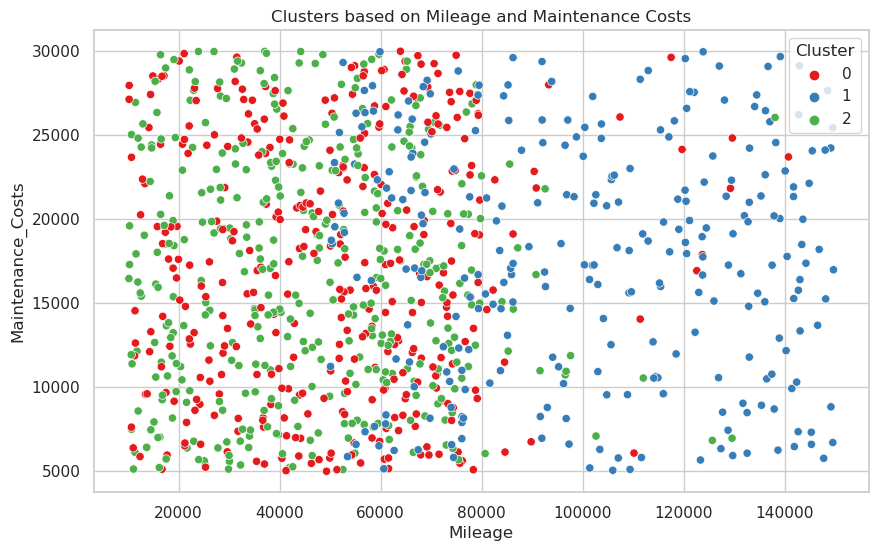

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


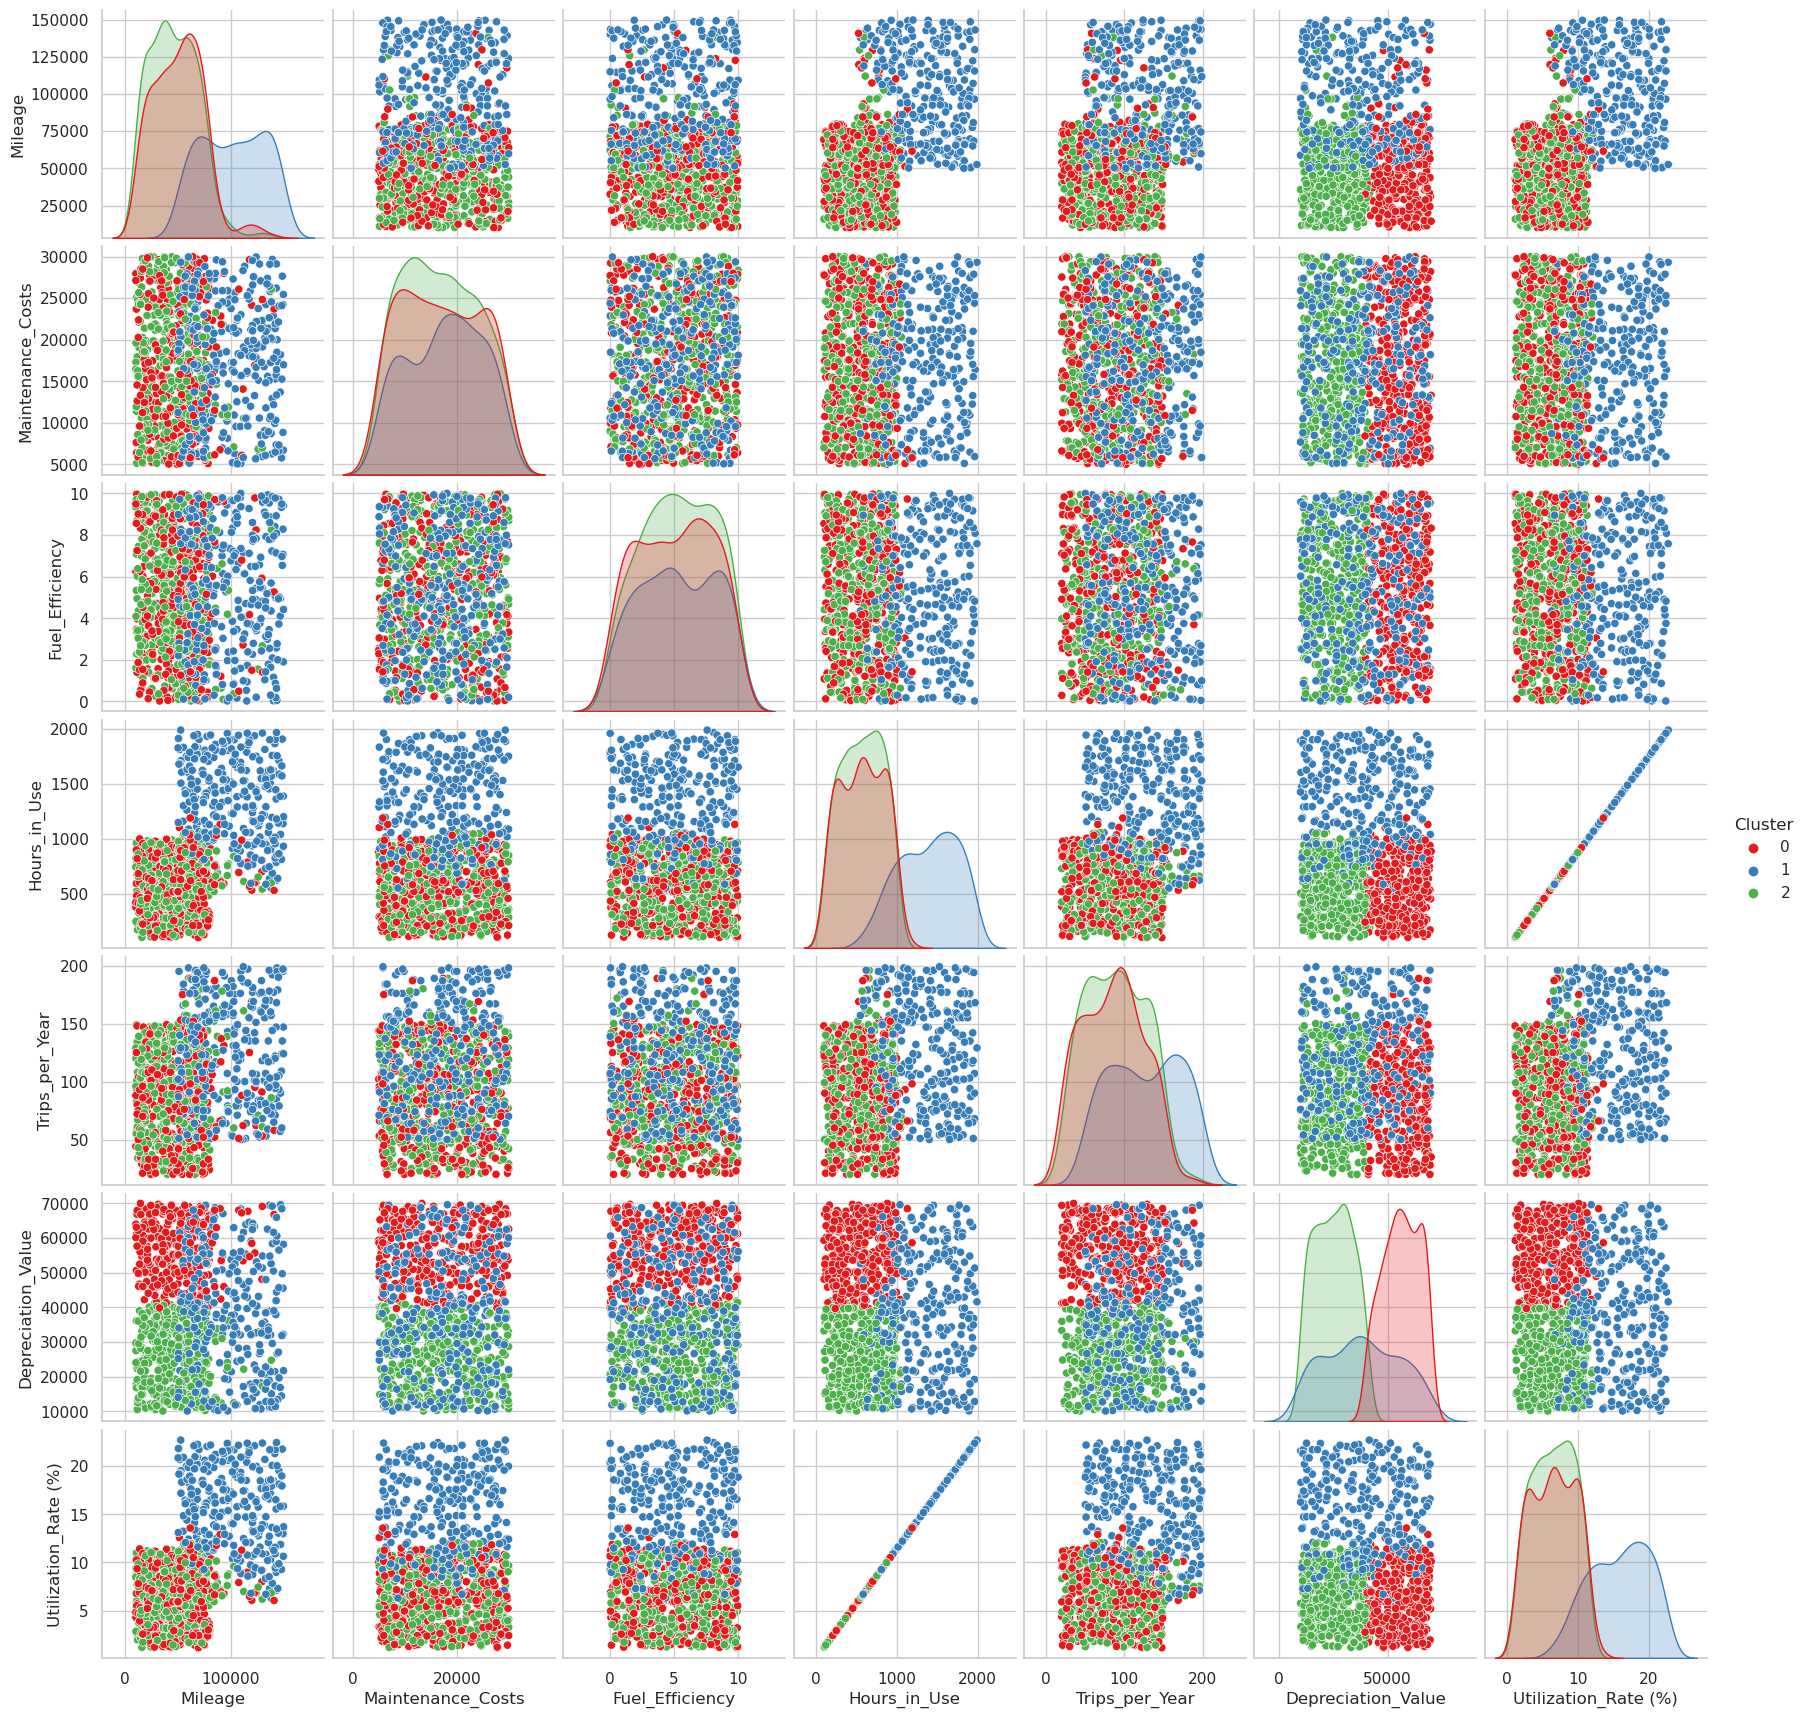

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

#Select the relevant numerical features that represent the usage patterns and costs.
# DataFrame with the selected features
features = ['Mileage', 'Maintenance_Costs', 'Fuel_Efficiency', 
            'Hours_in_Use', 'Trips_per_Year', 'Depreciation_Value', 'Utilization_Rate (%)']


#Standardize the data to ensure that all features contribute equally to the distance metrics used in clustering.
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# K-Means Clustering is commonly used for such purposes. You can start with it and adjust the number of clusters (k) based on the results.
# Hierarchical Clustering or DBSCAN are alternatives that can be explored depending on the data structure.

# Apply the chosen clustering algorithm to the standardized data.
# Step 2: Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose an appropriate k value
df['Cluster'] = kmeans.fit_predict(df_scaled)


# Use pair plots or other visualizations to see how different clusters are grouped based on the selected features.
# Step 3: Visualize the clusters (e.g., using Mileage and Maintenance_Costs)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage', y='Maintenance_Costs', hue='Cluster', data=df, palette='Set1')
plt.title('Clusters based on Mileage and Maintenance Costs')
plt.show()

# Optional: Visualize clusters using pairplot to see interactions between all features
sns.pairplot(df[features + ['Cluster']], hue='Cluster', palette='Set1') 
plt.show()

- Clusters based on Mileage and Maintenance Costs:
The clustering indicates distinct groupings of vehicles based on their mileage and maintenance costs.
Cluster 0 (red) seems to represent vehicles with lower mileage and maintenance costs.
Cluster 1 (blue) represents vehicles with higher mileage and varying maintenance costs.
Cluster 2 (green) might represent vehicles with medium mileage but still varying maintenance costs.
- Pairwise Relationships in Clusters:
Across the variables (Mileage, Maintenance Costs, Fuel Efficiency, Hours in Use, Trips per Year, Depreciation Value, Utilization Rate), distinct clusters are observed.
The blue cluster (1) generally shows higher values for Mileage, Maintenance Costs, and Depreciation Value, suggesting these vehicles are more heavily used and older.
The green cluster (2) tends to have moderate values across these variables.
The red cluster (0) consistently shows lower values, indicating these vehicles might be newer or less used.
- Utilization Rate Across Clusters:
Vehicles in Cluster 1 (blue) generally have higher utilization rates, aligning with their higher mileage and usage.
Cluster 0 (red) shows lower utilization, which could indicate underutilized assets.
The green cluster (2) again falls in between, suggesting balanced use.
- Distribution of Variables by Cluster:
The spread and density of variables like Mileage, Maintenance Costs, and Depreciation Value vary significantly across clusters.
The overlap between clusters, particularly in lower mileage and lower maintenance costs, could suggest a need to evaluate these vehicles further for optimization.

These insights can guide decisions on vehicle maintenance, replacement, and optimal utilization. They also suggest areas where further investigation or action may be needed to improve fleet efficiency.

# Correlation Matrix
Let's check the relationship between different variables using a heatmap

In [39]:
# Take a look at the columns
df.columns

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 41, Finished, Available, Finished)

Index(['Asset_ID', 'Asset_Type', 'Purchase_Date', 'Lifecycle_Status',
       'Maintenance_Costs', 'Replacement_Cost', 'Depreciation_Value',
       'Fuel_Type', 'Fuel_Efficiency', 'Mileage', 'Hours_in_Use', 'Department',
       'Trips_per_Year', 'Utilization_Rate (%)', 'Idle_Time', 'Cluster'],
      dtype='object')

# Encode selected categorical features

In [40]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder

# Columns to be encoded
categorical_columns = ['Asset_Type', 'Lifecycle_Status', 'Fuel_Type', 'Department']

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through each column and create a new encoded column
for col in categorical_columns:
    df[col + '_Encoded'] = le.fit_transform(df[col])

# Now df will contain the new encoded columns without replacing the original ones
print(df.head())  # To verify the new columns

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 42, Finished, Available, Finished)

     Asset_ID         Asset_Type Purchase_Date Lifecycle_Status  \
0  ASSET_0001  Special Equipment    2017-01-16      End of Life   
1  ASSET_0005  Special Equipment    2019-10-21      End of Life   
2  ASSET_0007  Special Equipment    2022-07-14      End of Life   
3  ASSET_0009  Special Equipment    2011-12-02       In Service   
4  ASSET_0010  Special Equipment    2014-12-30       In Service   

   Maintenance_Costs  Replacement_Cost  Depreciation_Value Fuel_Type  \
0              15005             99893               18286  Gasoline   
1               7846             92397               21022  Gasoline   
2              27182             51770               48269    Diesel   
3               6130             83831               22338    Diesel   
4              24742             49163               15984    Diesel   

   Fuel_Efficiency  Mileage  Hours_in_Use          Department  Trips_per_Year  \
0             9.00    79626           307  Emergency Services              94   
1 

# Correlation matrix on selected features
We used all numeric and encoded categorical features.

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 43, Finished, Available, Finished)

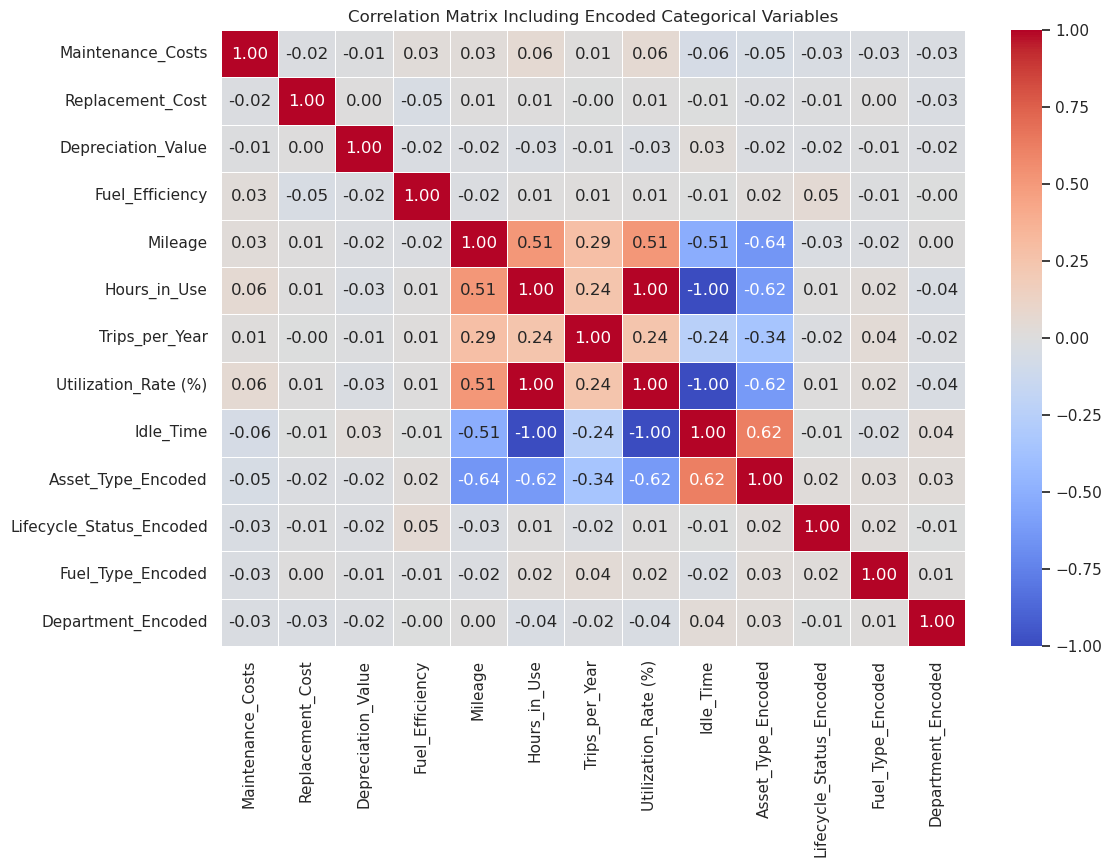

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all numeric columns and encoded categorical columns
numeric_columns = ['Maintenance_Costs', 'Replacement_Cost', 'Depreciation_Value',
                   'Fuel_Efficiency', 'Mileage', 'Hours_in_Use', 'Trips_per_Year',
                   'Utilization_Rate (%)', 'Idle_Time']

encoded_columns = ['Asset_Type_Encoded', 'Lifecycle_Status_Encoded', 'Fuel_Type_Encoded', 'Department_Encoded']

# Create a new dataframe containing only the selected columns
df_corr = df[numeric_columns + encoded_columns]

# Compute the correlation matrix
corr_matrix = df_corr.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Including Encoded Categorical Variables')
plt.show()

# Insight
- 1. Mileage and Hours in Use:There is a strong positive correlation between Mileage and Hours in Use (0.51). This indicates that as the number of hours a vehicle is in use increases, the mileage also tends to increase, which is expected.
- 2.	Idle Time and Utilization Rate:There is a very strong negative correlation between Idle Time and Utilization Rate (-1.00). This suggests that as the utilization rate increases, idle time decreases, and vice versa. This is logical because a higher utilization rate implies that the vehicle is being used more, leaving less idle time.
- 3.	Asset Type and Idle Time: There is a moderate positive correlation between Asset Type and Idle Time (0.62). This suggests that certain asset types might be associated with higher idle times.
- 4.	Asset Type and Mileage: There is a moderate negative correlation between Asset Type and Mileage (-0.64). This suggests that different asset types might have varying levels of mileage accumulation, with some types accumulating more miles than others.
- 5.	Lifecycle Status and Maintenance Costs: There is a weak positive correlation between Lifecycle Status and Maintenance Costs (0.02). This indicates that there may be a slight tendency for vehicles in different lifecycle statuses (e.g., In Service, End of Life) to incur varying maintenance costs, though the correlation is not strong.
- 6.	Department Encoded and Hours in Use: There is a weak negative correlation between Department and Hours in Use (-0.04). This indicates that vehicles used by different departments may have varying usage levels, but the relationship is not strong.
- 7.	Fuel Type and Mileage: There is a weak negative correlation between Fuel Type and Mileage (-0.03). This indicates that different fuel types may be associated with different mileage levels, though the relationship is weak.
- 8.	Maintenance Costs and Utilization Rate: There is a weak positive correlation between Maintenance Costs and Utilization Rate (0.06). This suggests that vehicles with higher maintenance costs might have slightly higher utilization rates, but the correlation is weak.

These insights provide an understanding of the relationships between various features in the dataset and very important for predictive modeling.

# Regression Models: 
Build models to predict utilization based on selected features

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Selecting features and target variable
features = ['Maintenance_Costs', 'Replacement_Cost', 'Depreciation_Value',
            'Fuel_Efficiency', 'Mileage', 'Hours_in_Use',
            'Asset_Type_Encoded', 'Lifecycle_Status_Encoded', 'Fuel_Type_Encoded', 'Department_Encoded']
target = 'Utilization_Rate (%)'

# Splitting the data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# The coefficients of the linear regression model are displayed to understand the impact of each feature.
# Optional: Display the model's coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 46, Finished, Available, Finished)

2024-08-26:14:48:46,634 WARNING  [tracking_store.py:153] log_inputs not supported


2024-08-26:14:48:52,489 WARNING  [tracking_store.py:153] log_inputs not supported


Mean Squared Error: 3.2770869344946215e-28
R-squared: 1.0
                           Coefficient
Maintenance_Costs        -1.016361e-19
Replacement_Cost          5.713880e-19
Depreciation_Value       -4.958181e-19
Fuel_Efficiency           3.838721e-15
Mileage                   2.242663e-19
Hours_in_Use              1.141553e-02
Asset_Type_Encoded       -1.383320e-16
Lifecycle_Status_Encoded  1.157464e-16
Fuel_Type_Encoded         3.950493e-20
Department_Encoded       -8.839555e-18


StatementMeta(, 11e743a5-8f41-40d3-9598-b0adedde1eaf, 47, Finished, Available, Finished)

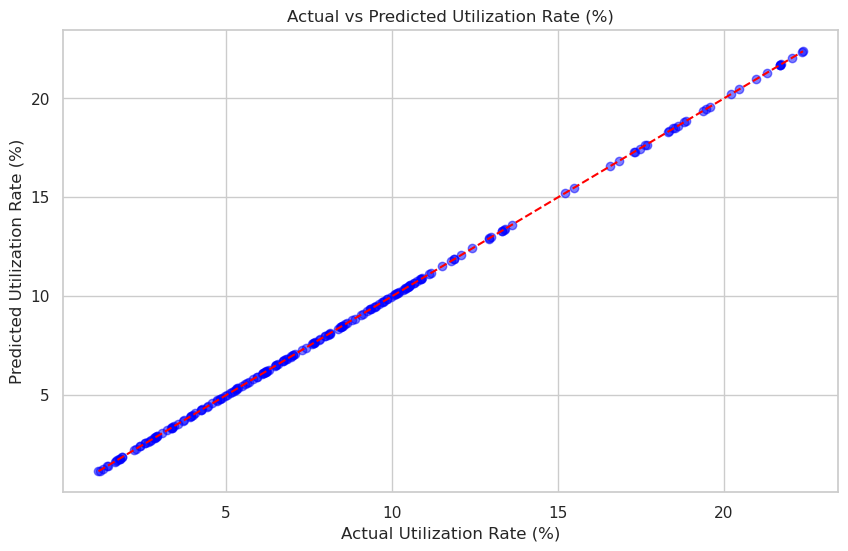

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot to visualize the predicted vs actual values
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line

plt.title('Actual vs Predicted Utilization Rate (%)')
plt.xlabel('Actual Utilization Rate (%)')
plt.ylabel('Predicted Utilization Rate (%)')

plt.show()

# Insight about performance of the model
 key insights regarding the model’s performance based on this visualization:

- 1.	High Accuracy: The points are closely aligned with the red diagonal line, which indicates that the predicted utilization rates are very close to the actual utilization rates. This suggests that the model is performing well and making accurate predictions.
- 2.	Low Variability: There is minimal spread around the diagonal line, implying that the model’s predictions are consistent and that there are few outliers or large errors.
- 3.	No Systematic Bias: The scatter plot does not show any systematic deviation from the diagonal line (such as consistent underprediction or overprediction), suggesting that the model is neither consistently overestimating nor underestimating the utilization rates.

Overall, this visual confirms that the model is well-fitted to the data and provides reliable predictions for utilization rates based on the selected features.

# Conclusions 

 R-Squared Value:

- The R-squared value is 1.0, which suggests that the model explains 100% of the variance in the utilization rate. This typically indicates a perfect fit, which might be unusual in real-world data unless the model is overfitted or the data is too simple.

- Mean Squared Error (MSE): The MSE is extremely close to zero (3.2770869344946215e-28), which indicates that the difference between the predicted values and the actual values is almost negligible. This further supports the notion of a near-perfect fit.

- Possible Overfitting: The combination of an R-squared value of 1.0, an extremely low MSE, and coefficients close to zero could indicate that the model is overfitted to the training data. This means that while the model performs exceptionally well on the training data, it might not generalize well to new, unseen data.

- Feature Importance: Since most coefficients are extremely small, it suggests that these features do not strongly influence the model’s predictions. The focus could be on the features with non-zero coefficients for further analysis.
It might also be worth revisiting feature selection or engineering to ensure the model captures meaningful relationships.

